# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [3]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

In [4]:
#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']


# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)

In [5]:
# display df header
data_top = df.head()   
data_top

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

### Drop null values

In [6]:
df.shape #before dropping nulls

(32561, 15)

In [7]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [8]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [9]:
#df['native-country'].value_counts()

In [10]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [11]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [12]:
df.shape

(27504, 16)

### Visualize the distribution of the categorical features

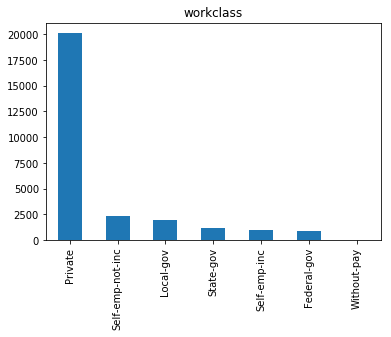

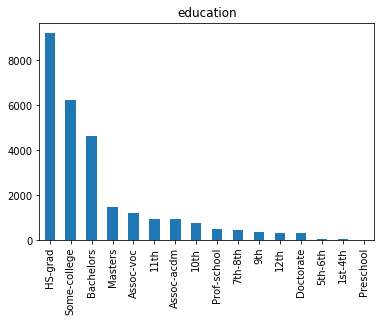

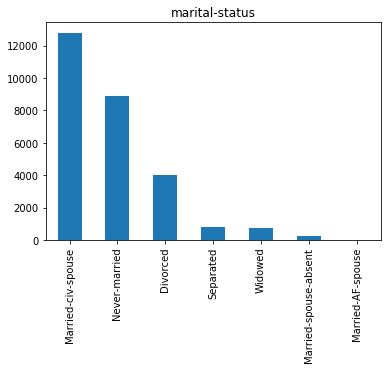

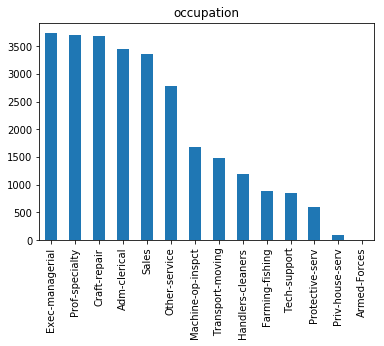

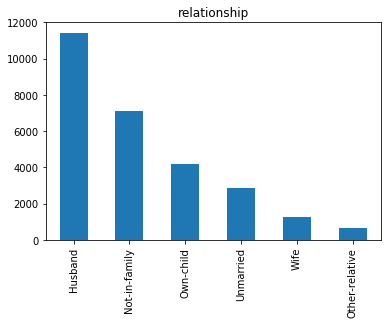

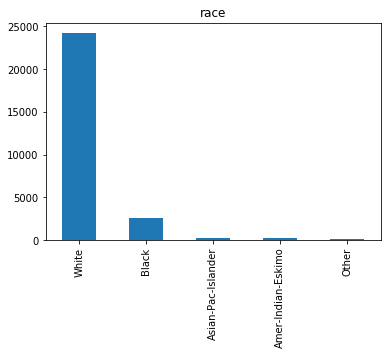

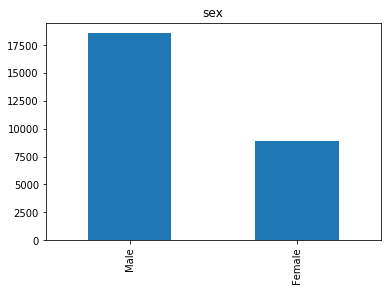

In [13]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

## Visualize the continuous feautures

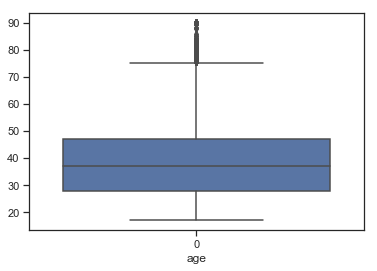

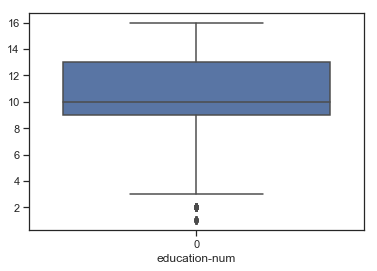

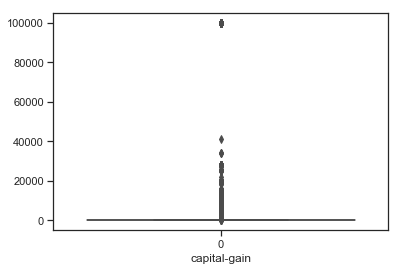

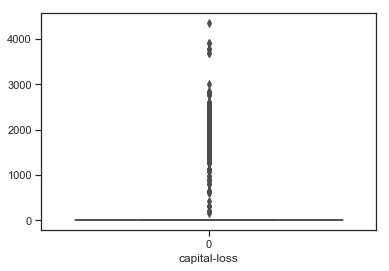

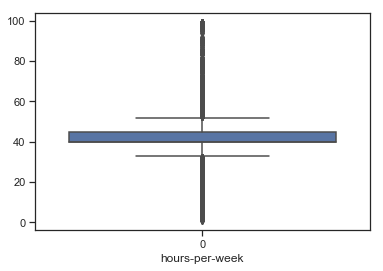

In [14]:
# to do
sns.set(style="ticks", color_codes=True)

string_columns = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

for col in string_columns: 
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=df[col]).set(
    xlabel=col
)


### One hot encode

In [15]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [16]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [17]:
new_df.head(10)

age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   37  284582             14             0             0              40   
5   52  209642              9             0             0              45   
6   31   45781             14         14084             0              50   
7   42  159449             13          5178             0              40   
8   37  280464             10             0             0              80   
9   23  122272             13             0             0              30   

   workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
0                      0                    0                  0   
1                      0                    0                  0   
2                      0                    0                  1   
3                      0                    0                  1   
4                      0                    0                  1   
5                      0                    0                  0   
6                      0                    0                  1   
7                      0                    0                  1   
8                      0                    0                  1   
9                      0                    0                  1   

   workclass_Self-emp-inc  ...  relationship_Other-relative  \
0                       0  ...                            0   
1                       0  ...                            0   
2                       0  ...                            0   
3                       0  ...                            0   
4                       0  ...                            0   
5                       0  ...                            0   
6                       0  ...                            0   
7                       0  ...                            0   
8                       0  ...                            0   
9                       0  ...                            0   

   relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                       0                       0                  0   
1                       0                       0                  0   
2                       0                       0                  0   
3                       0                       0                  0   
4                       0                       0                  1   
5                       0                       0                  0   
6                       0                       0                  0   
7                       0                       0                  0   
8                       0                       0                  0   
9                       1                       0                  0   

   race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  race_Other  \
0                        0                        0           0           0   
1                        0                        0           0           0   
2                        0                        0           0           0   
3                        0                        0           1           0   
4                        0                        0           0           0   
5                        0                        0           0           0   
6                        0                        0           0           0   
7                        0                        0           0           0   
8                        0                        0           1           0   
9                        0                        0           0           0   

   race_White  income  
0           1       0  
1

In [18]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [19]:
new_df = new_df.reset_index()

In [20]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Permutate/Shuffle the dataframe before applying algorithms

In [21]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

index  age  fnlwgt  education-num  capital-gain  capital-loss  \
9843    9843   25  171236              9             0             0   
21875  21875   37  295127             10             0             0   
5130    5130   31  206541             10             0             0   
26215  26215   53  239284              9             0             0   
8863    8863   38   33887              9             0             0   
24491  24491   19  100999             10             0             0   
8691    8691   26  190330             13             0             0   
10400  10400   32  117779              9             0             0   
1972    1972   35  199288              7             0             0   
19053  19053   52  373367              7             0             0   

       hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
9843               40                      0                    0   
21875              47                      0                    0   
5130               40                      0                    0   
26215              40                      0                    0   
8863               40                      0                    0   
24491              20                      0                    0   
8691               30                      0                    0   
10400              35                      0                    0   
1972               90                      0                    0   
19053              40                      0                    0   

       workclass_Private  ...  relationship_Other-relative  \
9843                   1  ...                            0   
21875                  1  ...                            0   
5130                   1  ...                            0   
26215                  1  ...                            0   
8863                   1  ...                            1   
24491                  1  ...                            0   
8691                   1  ...                            0   
10400                  1  ...                            0   
1972                   1  ...                            0   
19053                  1  ...                            0   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  \
9843                        1                       0                  0   
21875                       0                       0                  0   
5130                        0                       0                  0   
26215                       0                       1                  0   
8863                        0                       0                  0   
24491                       1                       0                  0   
8691                        0                       0                  0   
10400                       1                       0                  0   
1972                        0                       0                  0   
19053                       0                       0                  0   

       race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  \
9843                         0                        0           0   
21875                        0                        0           0   
5130                         0                        0           0   
26215                        0                        0           0   
8863                         0                        0           0   
24491                        0                        0           0   
8691                         0                        0           0   
10400                        0                        0           0   
1972                         0                        0           0   
19053                        0                        0           0   

       race_Other  race_White  income  
9843            0           1       0  
21875           0           1       0  
5130            0           1   

### Drop final weight (we don't need it)

In [22]:
new_df.drop(columns = ['fnlwgt'],inplace = True)
new_df.head(10)

index  age  education-num  capital-gain  capital-loss  hours-per-week  \
9843    9843   25              9             0             0              40   
21875  21875   37             10             0             0              47   
5130    5130   31             10             0             0              40   
26215  26215   53              9             0             0              40   
8863    8863   38              9             0             0              40   
24491  24491   19             10             0             0              20   
8691    8691   26             13             0             0              30   
10400  10400   32              9             0             0              35   
1972    1972   35              7             0             0              90   
19053  19053   52              7             0             0              40   

       workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
9843                       0                    0                  1   
21875                      0                    0                  1   
5130                       0                    0                  1   
26215                      0                    0                  1   
8863                       0                    0                  1   
24491                      0                    0                  1   
8691                       0                    0                  1   
10400                      0                    0                  1   
1972                       0                    0                  1   
19053                      0                    0                  1   

       workclass_Self-emp-inc  ...  relationship_Other-relative  \
9843                        0  ...                            0   
21875                       0  ...                            0   
5130                        0  ...                            0   
26215                       0  ...                            0   
8863                        0  ...                            1   
24491                       0  ...                            0   
8691                        0  ...                            0   
10400                       0  ...                            0   
1972                        0  ...                            0   
19053                       0  ...                            0   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  \
9843                        1                       0                  0   
21875                       0                       0                  0   
5130                        0                       0                  0   
26215                       0                       1                  0   
8863                        0                       0                  0   
24491                       1                       0                  0   
8691                        0                       0                  0   
10400                       1                       0                  0   
1972                        0                       0                  0   
19053                       0                       0                  0   

       race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  \
9843                         0                        0           0   
21875                        0                        0           0   
5130                         0                        0           0   
26215                        0                        0           0   
8863                         0                        0           0   
24491                        0                        0           0   
8691                         0                        0           0   
10400                        0                        0           0   
1972                         0                        0           0   
19053                        0                  

In [23]:
# Look at the class imbalance

In [26]:
df['income'].value_counts()

<=50K    20509
>50K      6995
Name: income, dtype: int64

### Get indexes for each individual feature and their respective names

In [27]:
ranges = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,13],[13,20],[20,34],[34,40],[40,45],[1,45]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Function to return results for each classifier

In [33]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()
    
    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()
    
    return [scores, clf.score(X_train,Y_train), score_f1]

### Classifiers we will use with different initializations

In [34]:
#classifiers we will use with different initializations
classifiers = [SVC(kernel = 'linear',gamma ='auto',random_state = 50)]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50,class_weight = 'balanced'))
classifiers.append(MLPClassifier(activation = 'relu',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.

### Name of the Classifiers

In [35]:
names = ['SVM with Linear Kernel','SVM with Linear Kernel and balanced class weight',
         'Neural Network with ReLU activation',
         'Neural Network with Logistic Sigmoid activation',
         'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

6.948675870895386 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


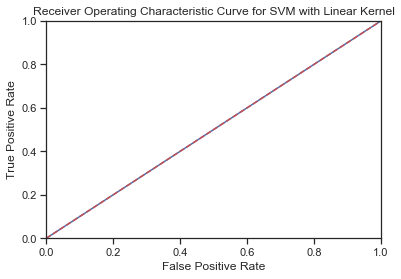


---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

7.1483728885650635 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


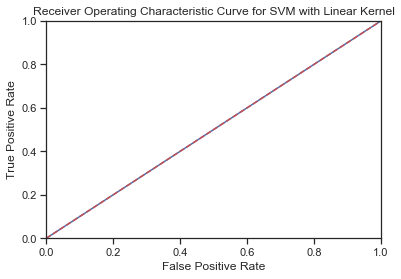


---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

7.132427215576172 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


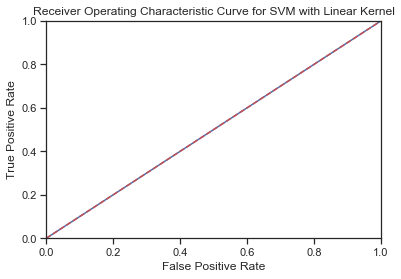


---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

7.684345960617065 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


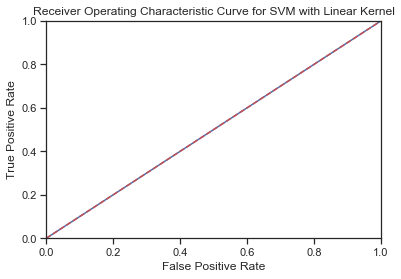


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

20.66971516609192 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6215970549470526
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6487716105550501

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2494       1560
True >50k        488        959

F1-score is: 0.48361069087241554


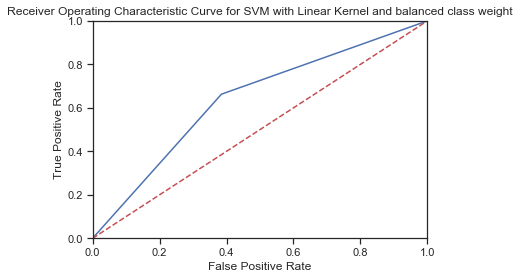


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

19.610389232635498 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6215970549470526
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6487716105550501

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2494       1560
True >50k        488        959

F1-score is: 0.48361069087241554


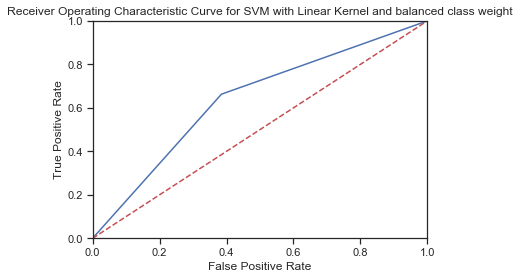


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

19.652156829833984 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6215970549470526
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6487716105550501

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2494       1560
True >50k        488        959

F1-score is: 0.48361069087241554


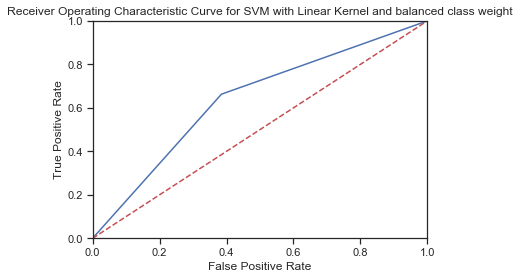


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

20.563968896865845 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6215970549470526
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6487716105550501

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2494       1560
True >50k        488        959

F1-score is: 0.48361069087241554


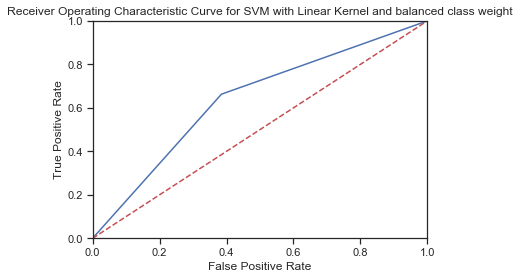


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.9632620811462402 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


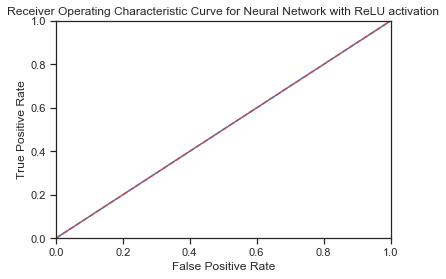


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.15360260009765625 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


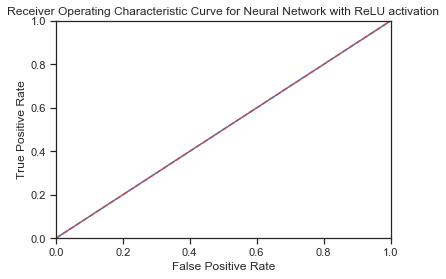


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.8155066967010498 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


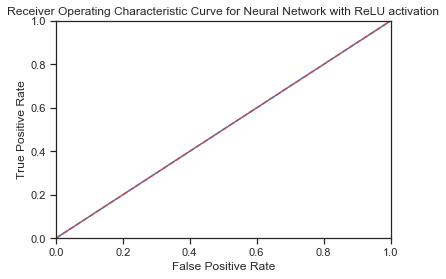


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.11880731582641602 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


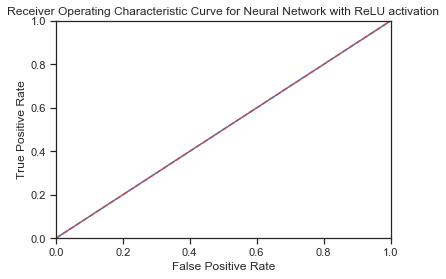


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.8362631797790527 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


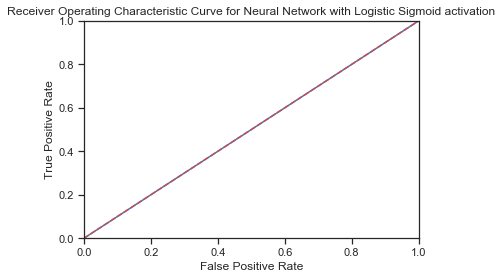


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.5050299167633057 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


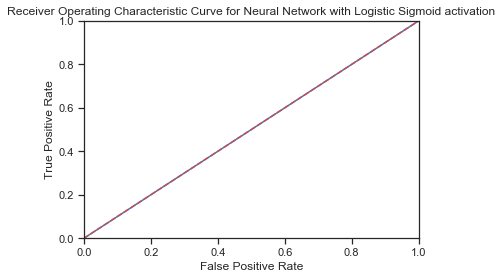


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

1.0570857524871826 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


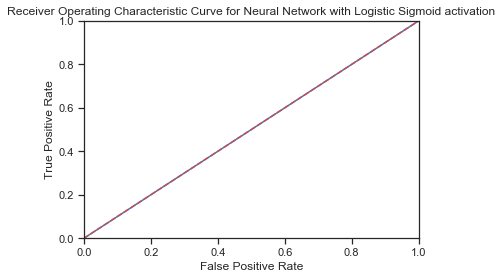


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.5614461898803711 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


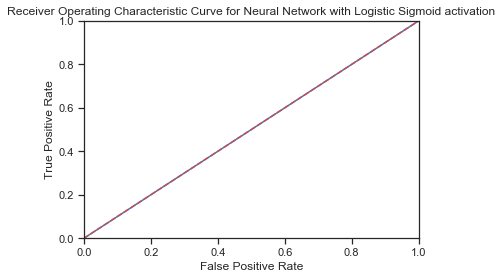


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.8160099983215332 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


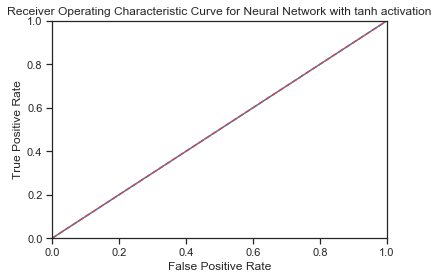


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.7120583057403564 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


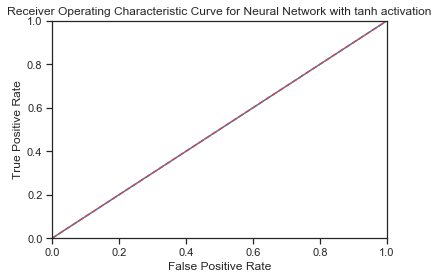


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.7386040687561035 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


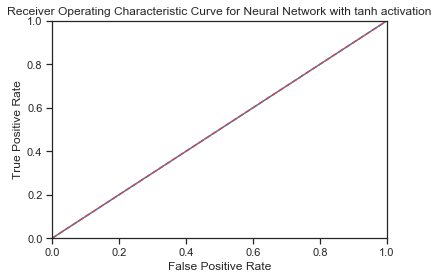


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.735588550567627 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


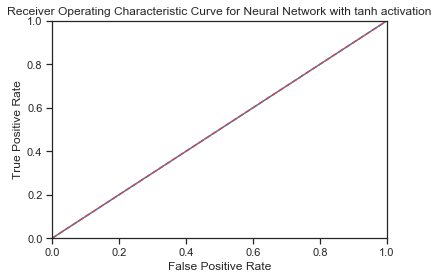


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.003991603851318359 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


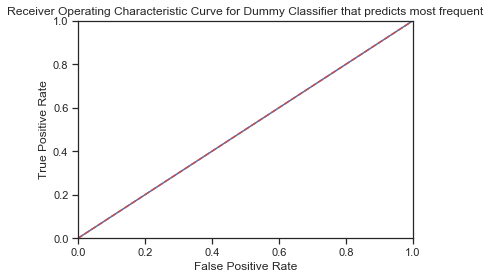


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.004070758819580078 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


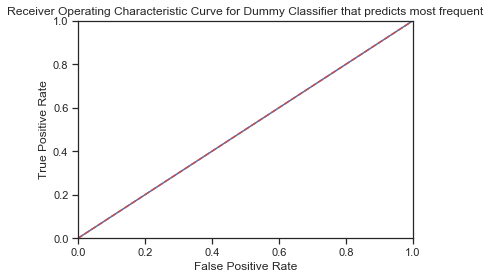


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.004065036773681641 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


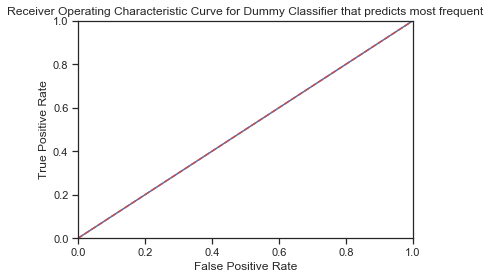


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.004150867462158203 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


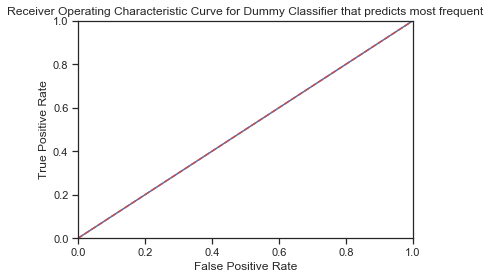


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

10.104143142700195 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


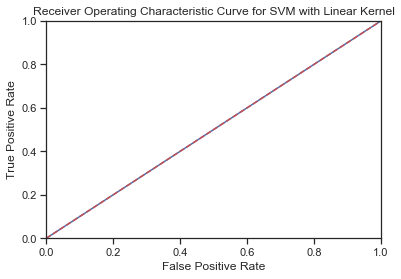


---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

10.143976926803589 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


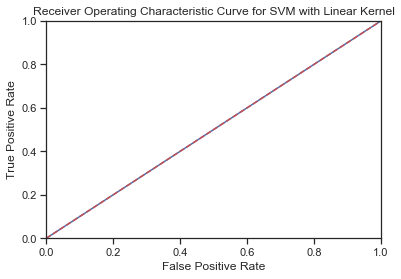


---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

10.591496706008911 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


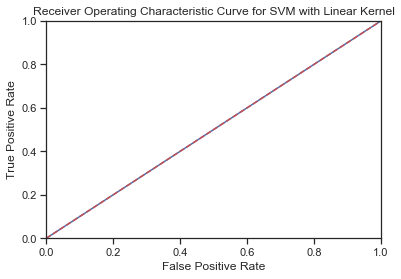


---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

9.47374677658081 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


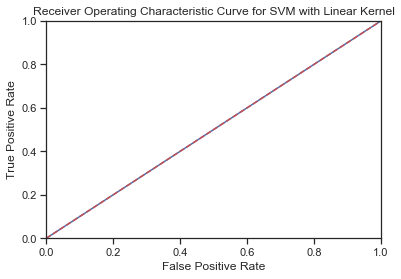


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

18.278853178024292 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.728264327591692
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7329700272479565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3237        817
True >50k        700        747

F1-score is: 0.49618067087346396


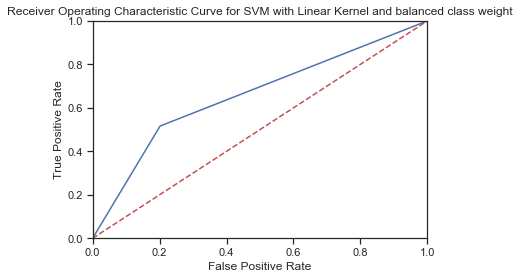


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

18.401819467544556 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.728264327591692
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7329700272479565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3237        817
True >50k        700        747

F1-score is: 0.49618067087346396


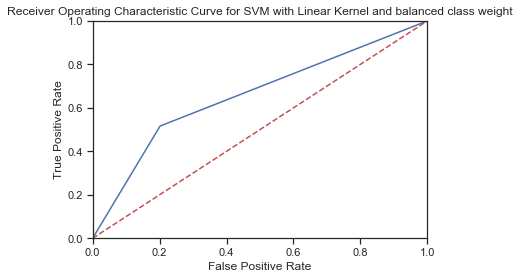


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

17.772841215133667 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.728264327591692
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7329700272479565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3237        817
True >50k        700        747

F1-score is: 0.49618067087346396


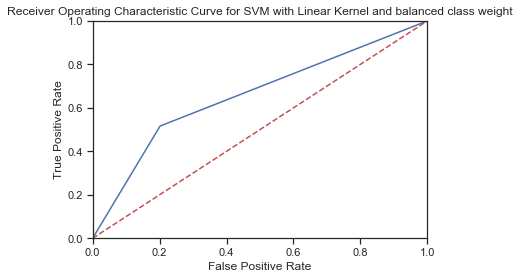


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

19.232152223587036 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.728264327591692
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7329700272479565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3237        817
True >50k        700        747

F1-score is: 0.49618067087346396


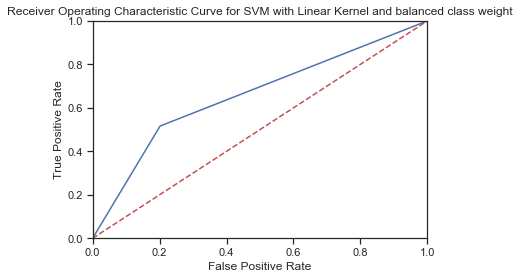


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.9531736373901367 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


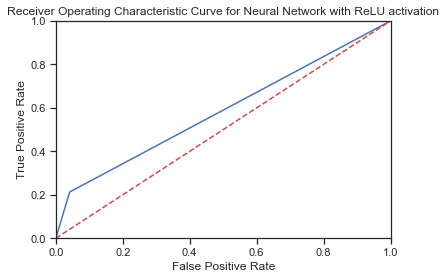


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

1.1923856735229492 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


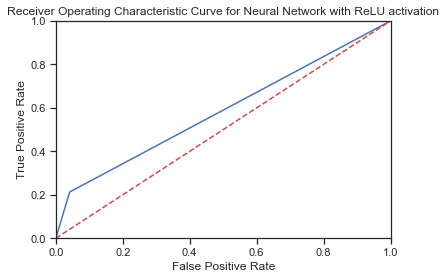


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.9598431587219238 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


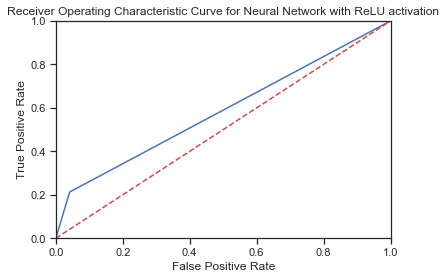


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.5501344203948975 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


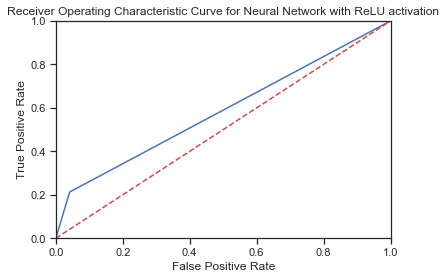


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.6630666255950928 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


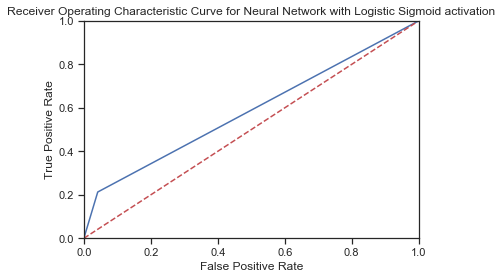


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.608212947845459 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


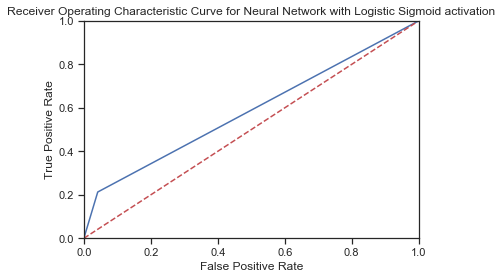


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.6935515403747559 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


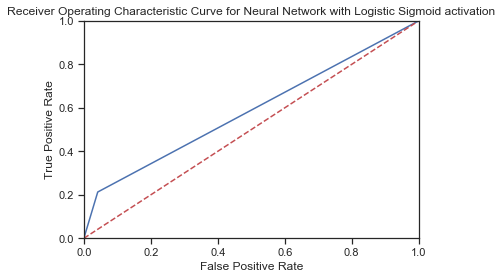


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.7280926704406738 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


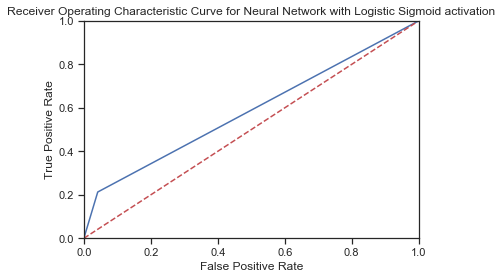


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.6818718910217285 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


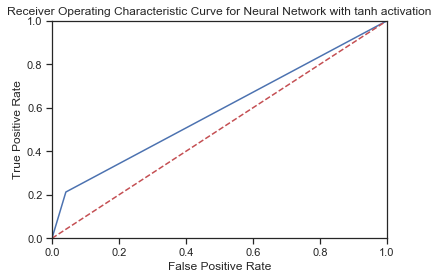


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.6286849975585938 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


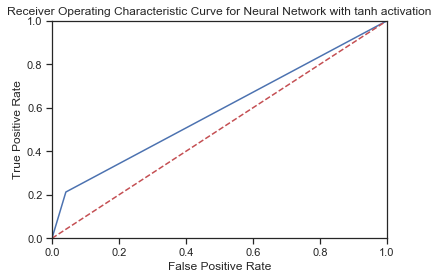


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.9805011749267578 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


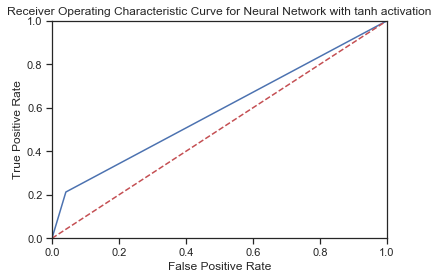


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

1.1239826679229736 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.769849565968277
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7624068351208871

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3886        168
True >50k       1139        308

F1-score is: 0.3203328133125325


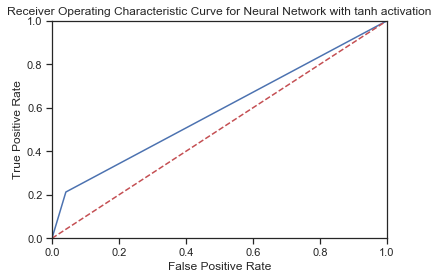


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.004311323165893555 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


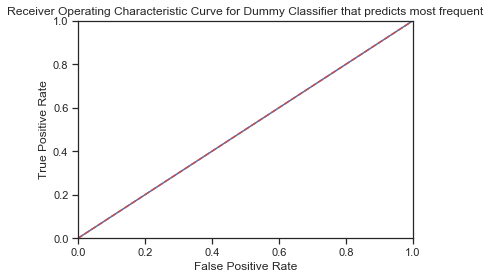


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.005133628845214844 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


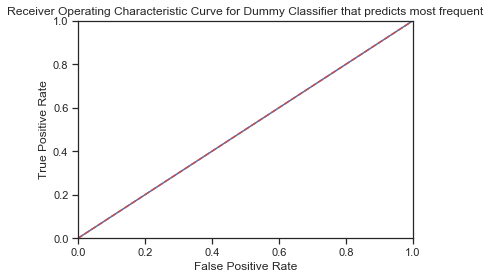


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.004336833953857422 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


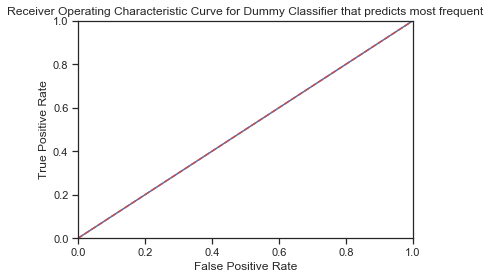


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.0040645599365234375 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


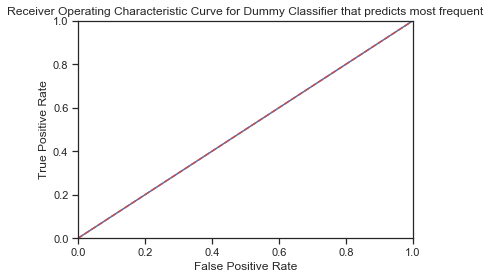


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

4.9253621101379395 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7869835931463891
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7845454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3987         67
True >50k       1151        296

F1-score is: 0.3270718232044199


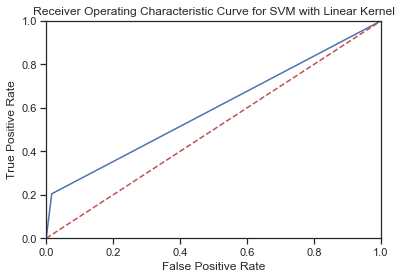


---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

4.840138912200928 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7869835931463891
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7845454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3987         67
True >50k       1151        296

F1-score is: 0.3270718232044199


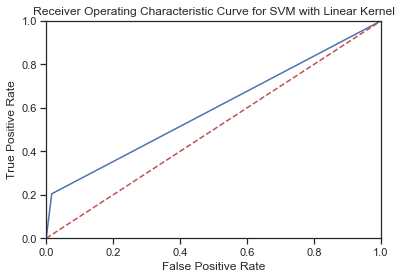


---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

5.3747780323028564 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7869835931463891
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7845454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3987         67
True >50k       1151        296

F1-score is: 0.3270718232044199


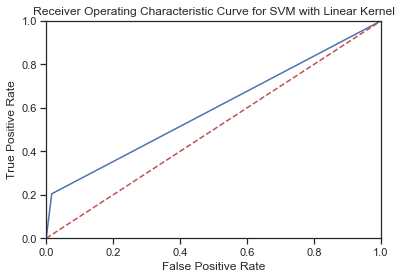


---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

4.934122085571289 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7869835931463891
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7845454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3987         67
True >50k       1151        296

F1-score is: 0.3270718232044199


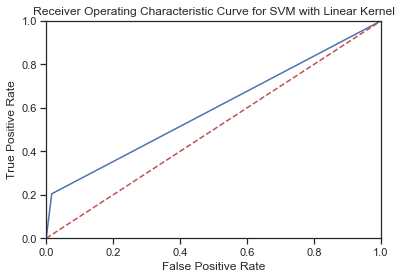


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

12.197091102600098 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7801663409535063
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7807097361237488

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3936        118
True >50k       1130        317

F1-score is: 0.33687566418703513


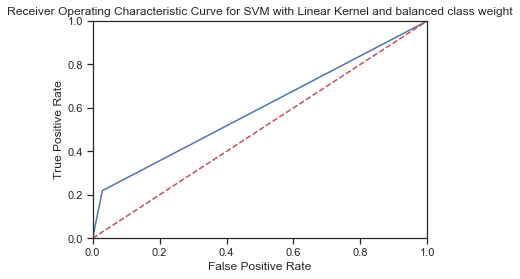


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

11.644829034805298 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7801663409535063
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7807097361237488

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3936        118
True >50k       1130        317

F1-score is: 0.33687566418703513


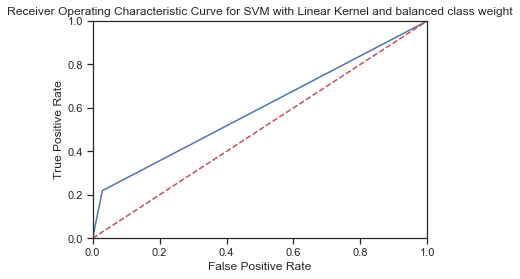


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

10.803783178329468 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7801663409535063
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7807097361237488

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3936        118
True >50k       1130        317

F1-score is: 0.33687566418703513


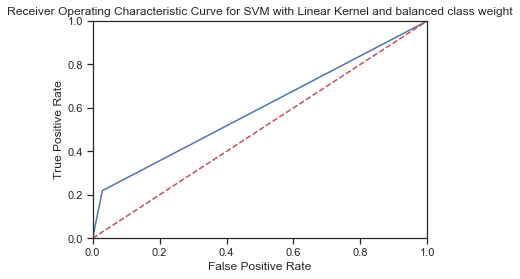


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

10.843605518341064 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7801663409535063
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7807097361237488

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3936        118
True >50k       1130        317

F1-score is: 0.33687566418703513


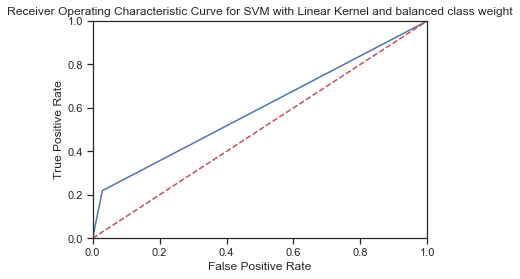


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.7410707473754883 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7884379402808708
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7793128522086893

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3991         63
True >50k       1151        296

F1-score is: 0.327796234772979


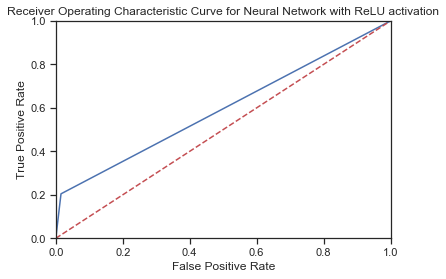


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.20632505416870117 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


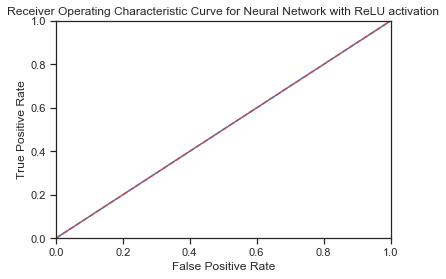


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.9246041774749756 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7869835931463891
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7785857116887839

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3987         67
True >50k       1151        296

F1-score is: 0.3270718232044199


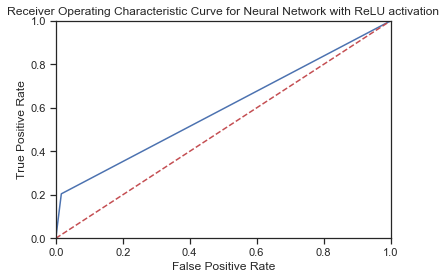


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

2.0204145908355713 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7930282234240785
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.784584620978004

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4037         17
True >50k       1168        279

F1-score is: 0.32013769363166955


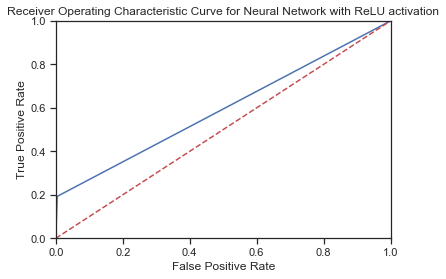


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.9261703491210938 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7903922192428305
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7818578440283585

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4019         35
True >50k       1165        282

F1-score is: 0.3197278911564626


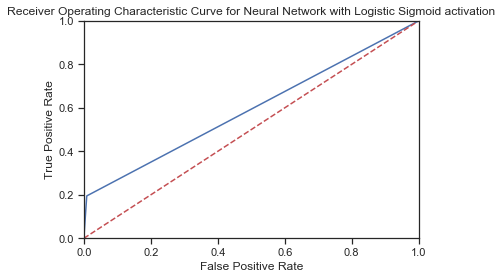


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.5604174137115479 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7909830477662136
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7824031994182876

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4022         32
True >50k       1165        282

F1-score is: 0.32027257240204426


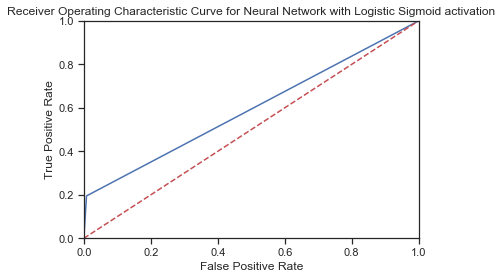


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.7184405326843262 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7903922192428305
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7818578440283585

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4019         35
True >50k       1165        282

F1-score is: 0.3197278911564626


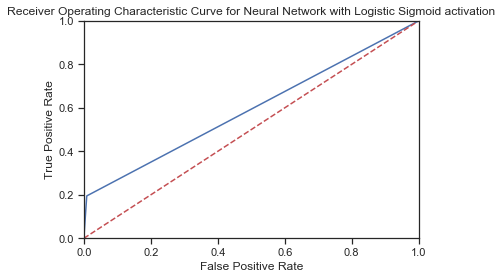


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.712108850479126 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7911648411580239
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.782584984548264

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4019         35
True >50k       1161        286

F1-score is: 0.3235294117647059


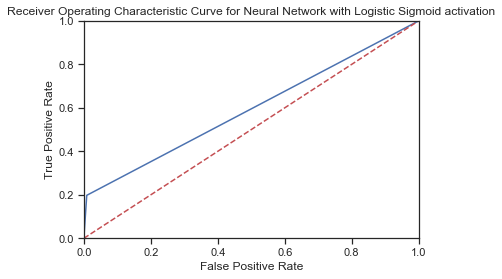


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.5104267597198486 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7898013907194473
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7820396291583348

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038         16
True >50k       1183        264

F1-score is: 0.3057324840764331


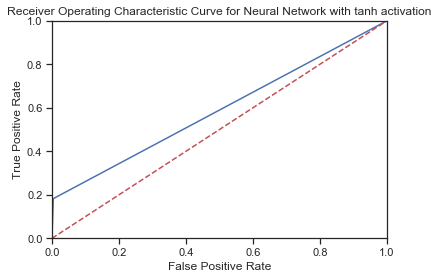


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.4492006301879883 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7898013907194473
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7820396291583348

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038         16
True >50k       1183        264

F1-score is: 0.3057324840764331


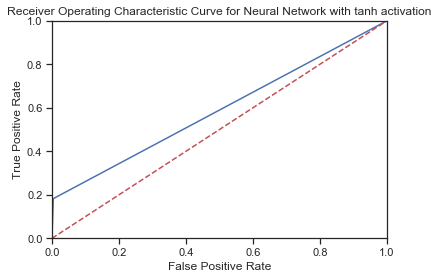


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.5753488540649414 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7898013907194473
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7820396291583348

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038         16
True >50k       1183        264

F1-score is: 0.3057324840764331


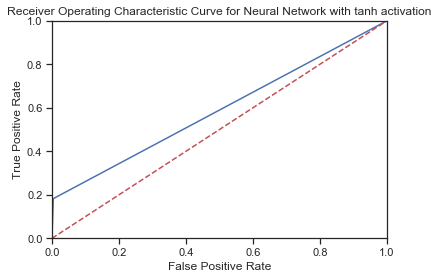


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.2987027168273926 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7898013907194473
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7820396291583348

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038         16
True >50k       1183        264

F1-score is: 0.3057324840764331


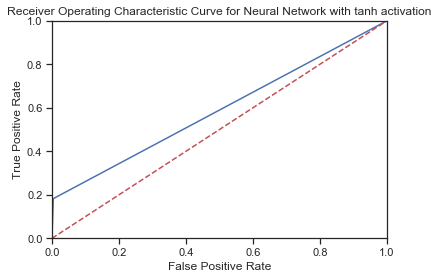


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.008579492568969727 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


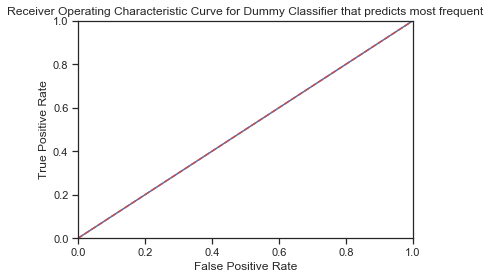


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.0052983760833740234 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


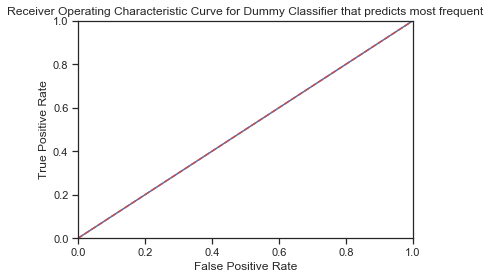


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.004079341888427734 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


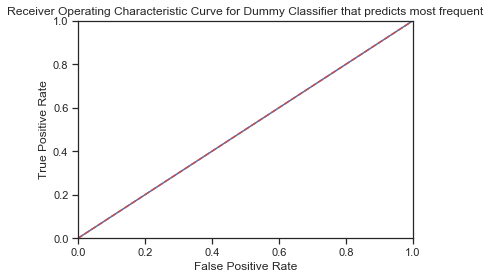


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.004052877426147461 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


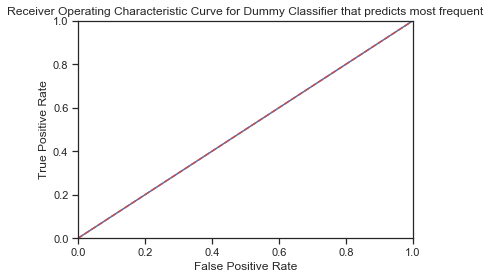


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

5.368299245834351 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7497159478252966
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3952        102
True >50k       1302        145

F1-score is: 0.17119244391971666


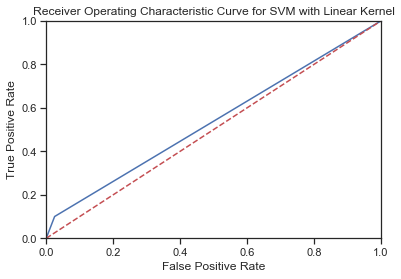


---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

5.990737199783325 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7497159478252966
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3952        102
True >50k       1302        145

F1-score is: 0.17119244391971666


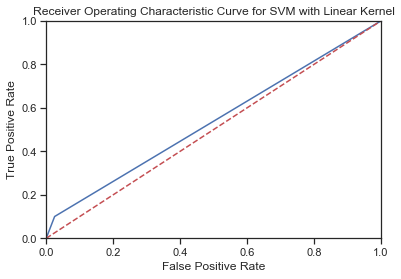


---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

5.0928120613098145 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7497159478252966
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3952        102
True >50k       1302        145

F1-score is: 0.17119244391971666


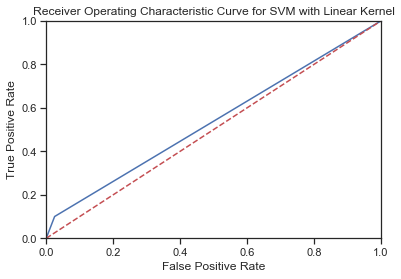


---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

3.0276827812194824 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7497159478252966
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3952        102
True >50k       1302        145

F1-score is: 0.17119244391971666


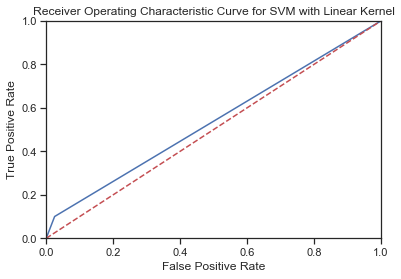


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

392.59313440322876 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7494432577375812
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3949        105
True >50k       1302        145

F1-score is: 0.1708898055391868


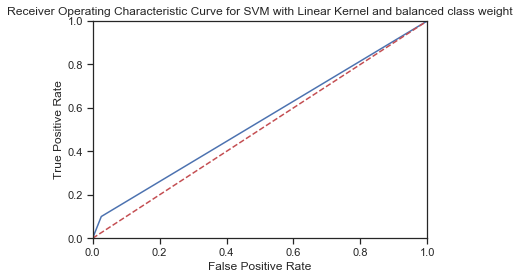


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

5.385359048843384 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7494432577375812
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3949        105
True >50k       1302        145

F1-score is: 0.1708898055391868


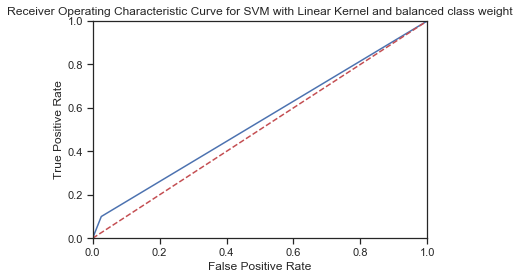


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

5.744653940200806 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7494432577375812
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3949        105
True >50k       1302        145

F1-score is: 0.1708898055391868


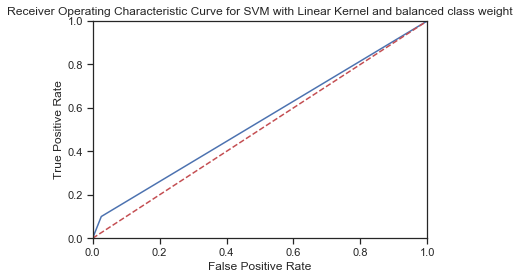


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

5.391168117523193 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7494432577375812
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3949        105
True >50k       1302        145

F1-score is: 0.1708898055391868


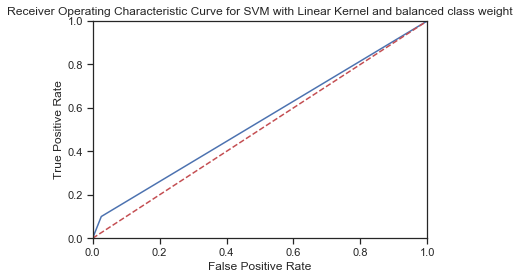


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.7217621803283691 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7618052083806753
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


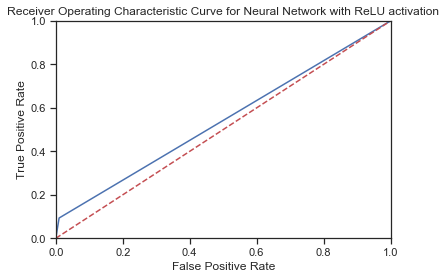


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.9915080070495605 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7617597600327228
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


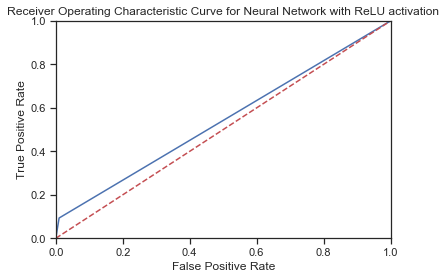


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.1749563217163086 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7586238240239968
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7522268678422105

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4003         51
True >50k       1312        135

F1-score is: 0.1653398652786283


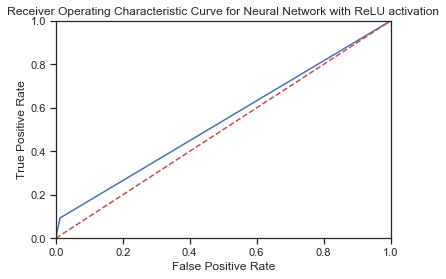


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.8315105438232422 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7617143116847702
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7540447191419742

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4013         41
True >50k       1312        135

F1-score is: 0.16635859519408505


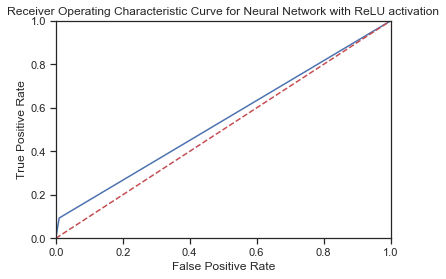


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.4597635269165039 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7616234149888651
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


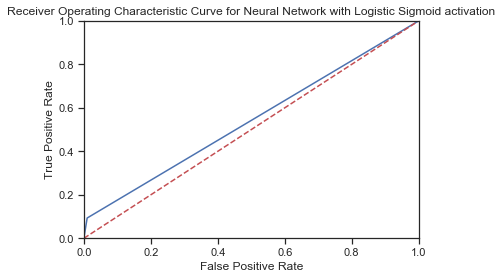


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.5255677700042725 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7616688633368177
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


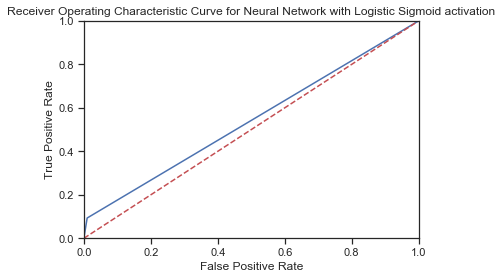


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.28063297271728516 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7616234149888651
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


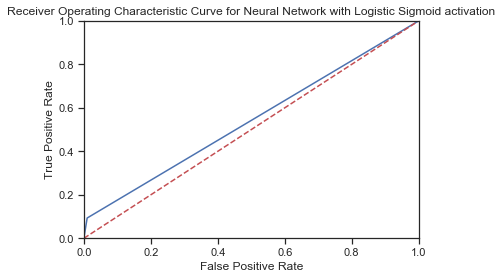


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.3874480724334717 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7616234149888651
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7542265042719506

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4014         40
True >50k       1312        135

F1-score is: 0.16646115906288533


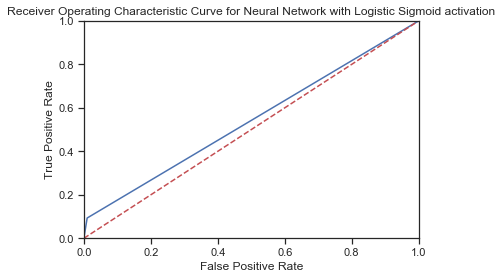


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.7265005111694336 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7617143116847702
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7540447191419742

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4013         41
True >50k       1312        135

F1-score is: 0.16635859519408505


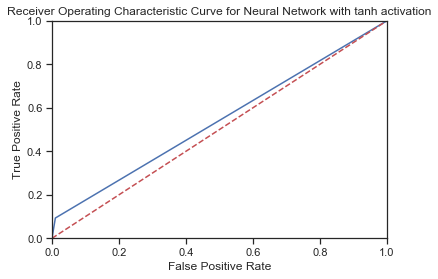


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.4953458309173584 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7617143116847702
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7540447191419742

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4013         41
True >50k       1312        135

F1-score is: 0.16635859519408505


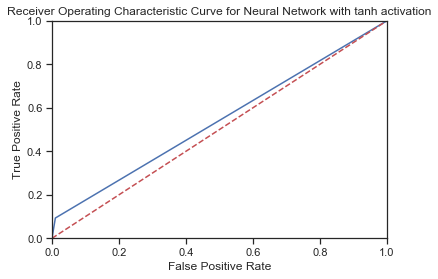


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.44574928283691406 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7617143116847702
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7540447191419742

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4013         41
True >50k       1312        135

F1-score is: 0.16635859519408505


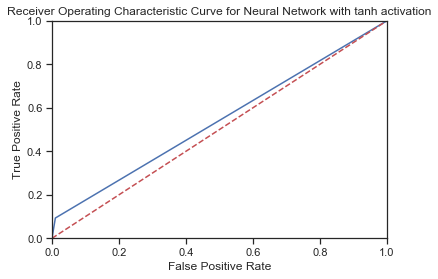


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.5172648429870605 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7617143116847702
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7540447191419742

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4013         41
True >50k       1312        135

F1-score is: 0.16635859519408505


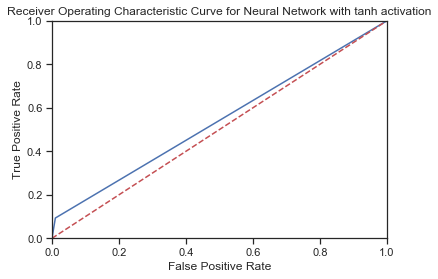


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.0 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


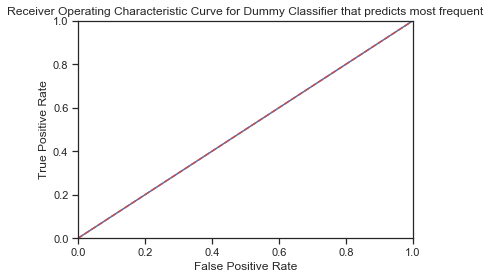


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.0 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


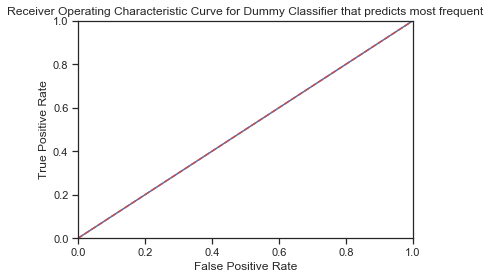


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.003990888595581055 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


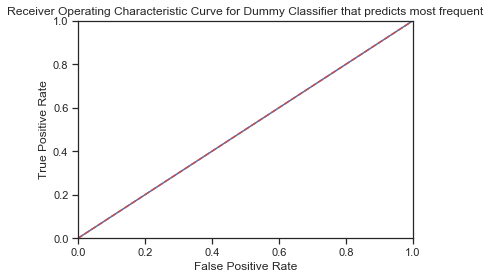


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.0039997100830078125 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


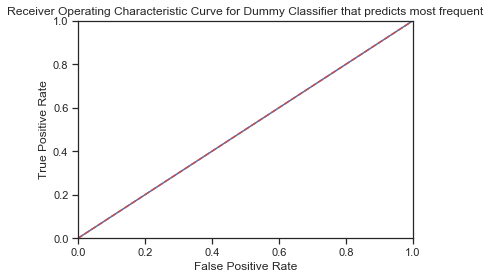


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

4.7687668800354 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


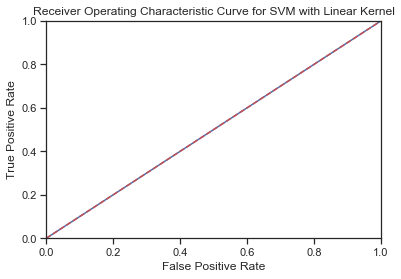


---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

5.077635288238525 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


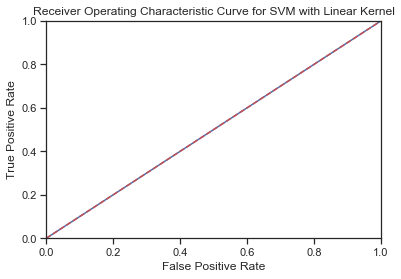


---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

4.935872793197632 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


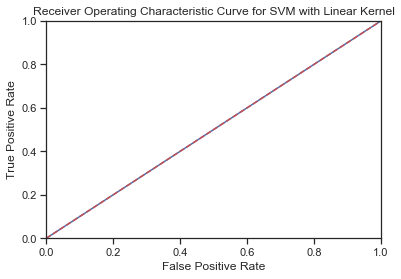


---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

5.042519569396973 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


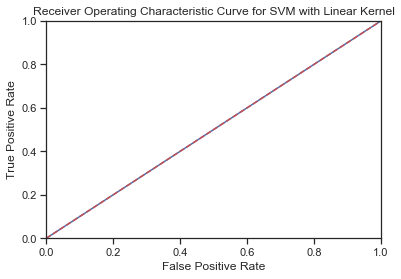


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

16.396719694137573 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.692860064536654
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7227272727272728

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3122        932
True >50k        734        713

F1-score is: 0.4611901681759379


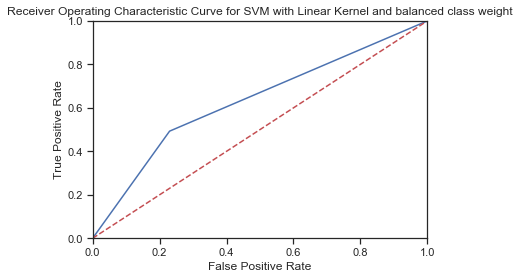


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

22.917473793029785 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.692860064536654
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7227272727272728

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3122        932
True >50k        734        713

F1-score is: 0.4611901681759379


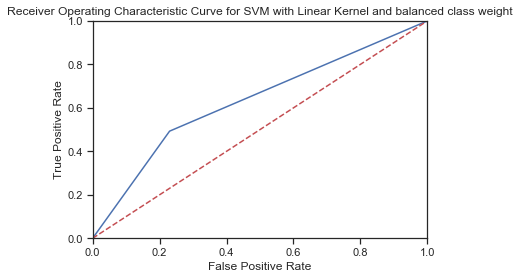


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

21.7103910446167 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.692860064536654
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7227272727272728

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3122        932
True >50k        734        713

F1-score is: 0.4611901681759379


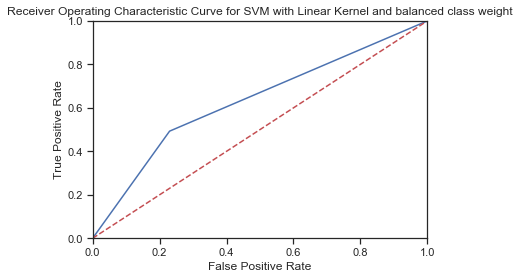


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

22.02608561515808 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.692860064536654
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7227272727272728

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3122        932
True >50k        734        713

F1-score is: 0.4611901681759379


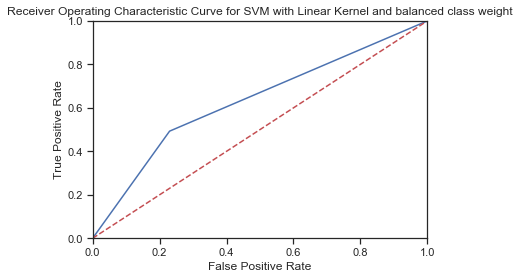


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

1.5104095935821533 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


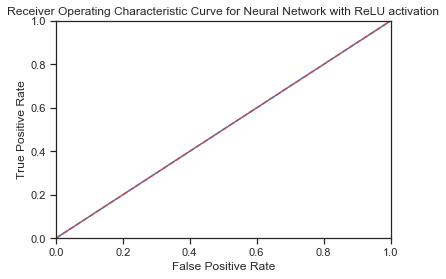


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

1.0001068115234375 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


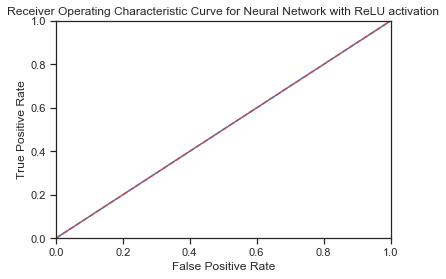


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.5752072334289551 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


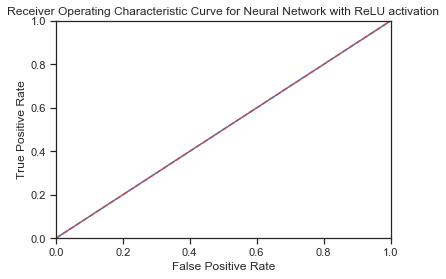


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

1.4146976470947266 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


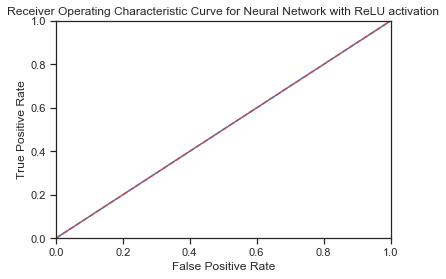


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.5537014007568359 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


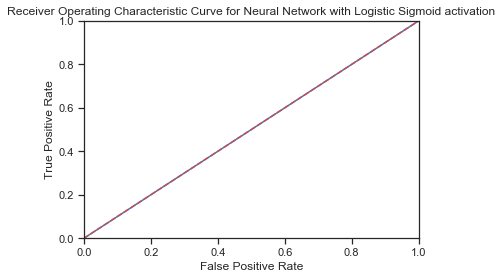


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.6027493476867676 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


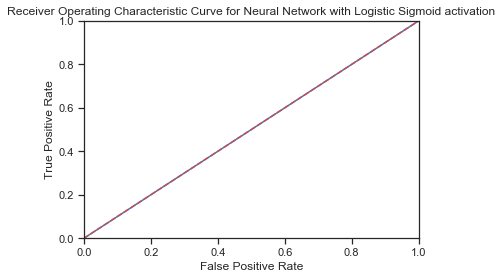


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.6482594013214111 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


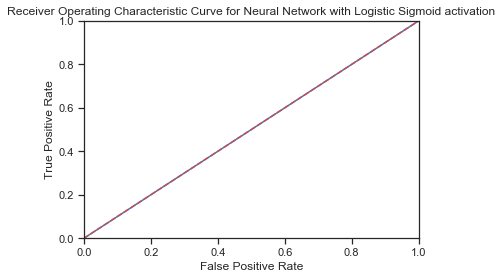


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.40707898139953613 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


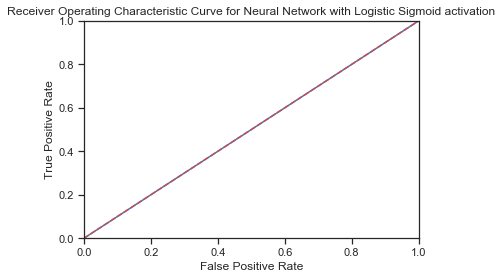


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.4283895492553711 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


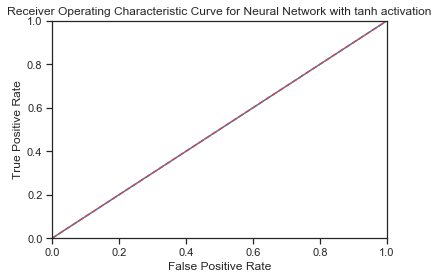


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.43007516860961914 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


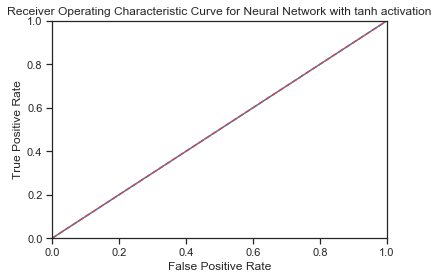


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.5293443202972412 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


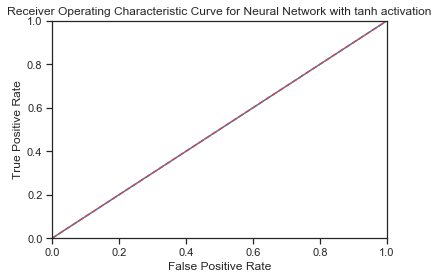


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.7865307331085205 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


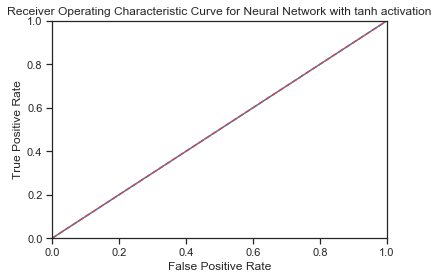


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.00399470329284668 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


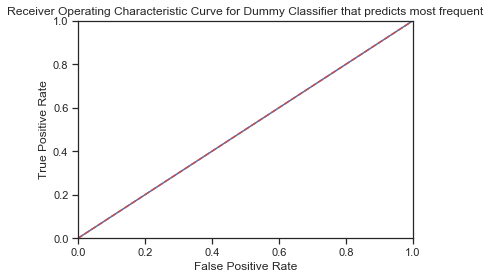


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.0036575794219970703 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


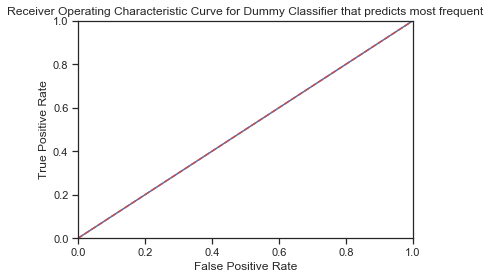


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.006699323654174805 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


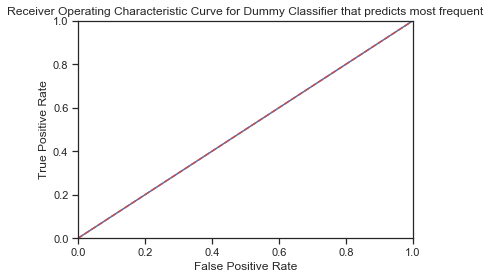


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.00499272346496582 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


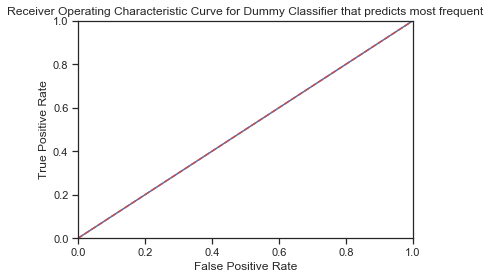


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

10.342583179473877 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7606915377616015

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


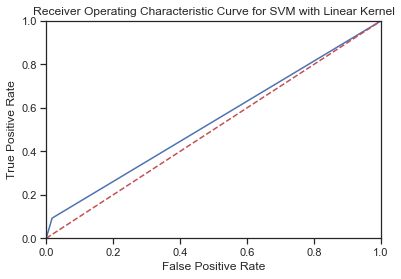


---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

9.980930089950562 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7606915377616015

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


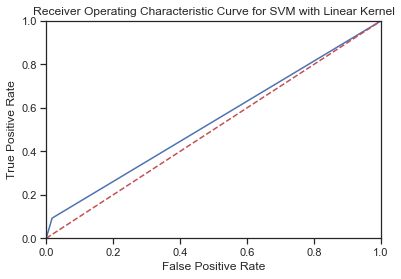


---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

9.807561874389648 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7606915377616015

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


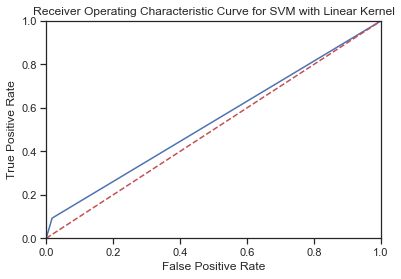


---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

10.568110466003418 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7606915377616015

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


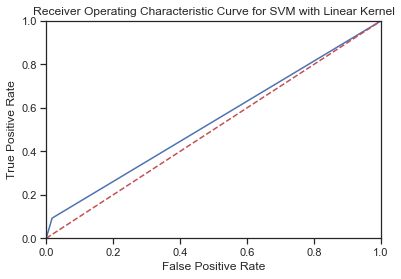


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

20.92139458656311 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.657274008089806
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6778889899909009

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3087        967
True >50k        935        512

F1-score is: 0.3499658236500342


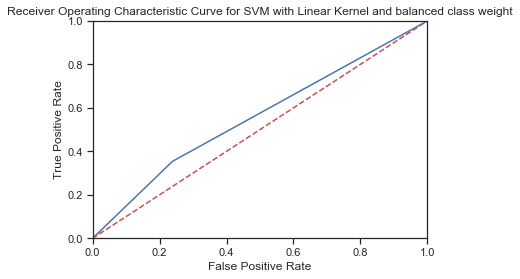


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

22.597441911697388 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.657274008089806
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6778889899909009

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3087        967
True >50k        935        512

F1-score is: 0.3499658236500342


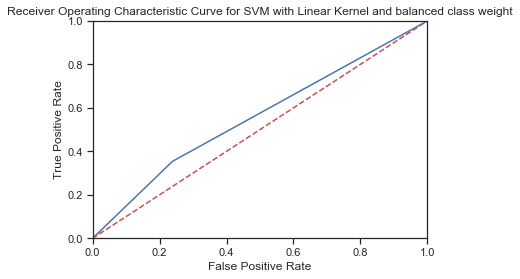


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

20.842979669570923 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.657274008089806
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6778889899909009

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3087        967
True >50k        935        512

F1-score is: 0.3499658236500342


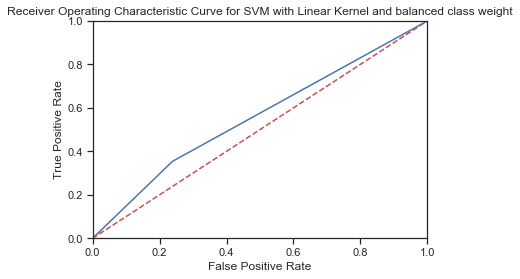


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

1560.0281281471252 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.657274008089806
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6778889899909009

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3087        967
True >50k        935        512

F1-score is: 0.3499658236500342


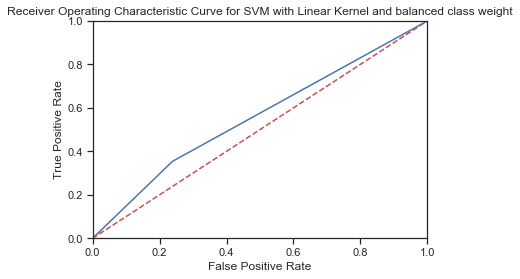


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.5936050415039062 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


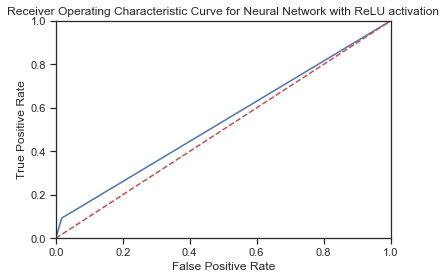


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.5179381370544434 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


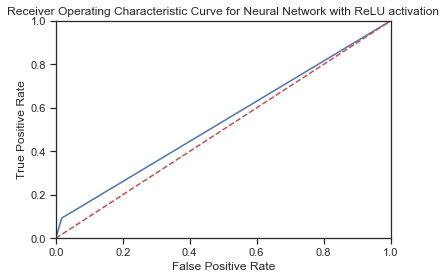


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.5979886054992676 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


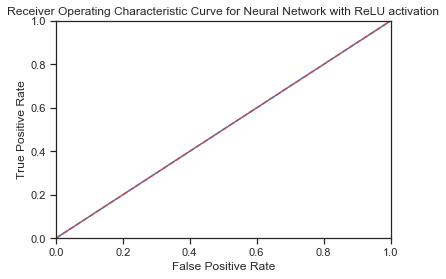


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.6648836135864258 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


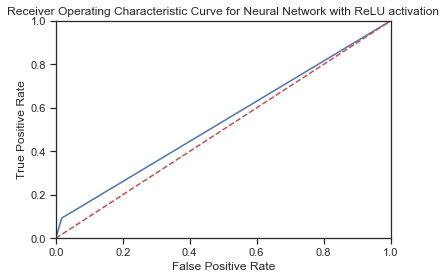


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.337646484375 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


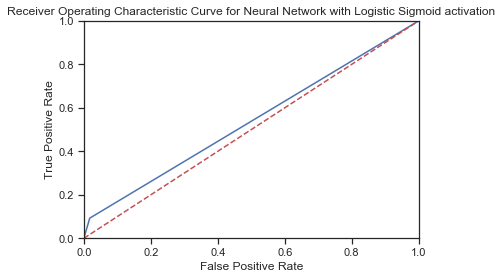


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.28362131118774414 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


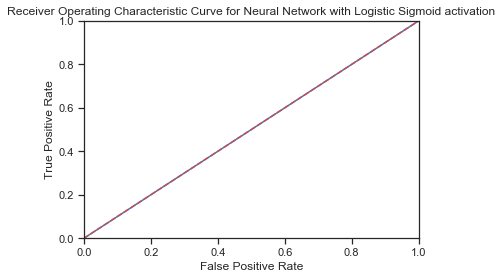


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.352738618850708 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


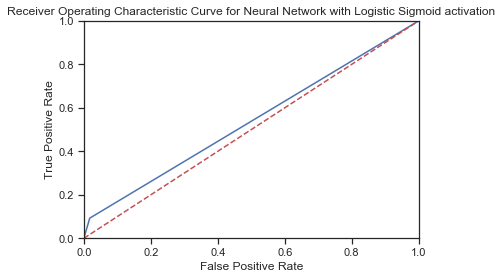


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.43941235542297363 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


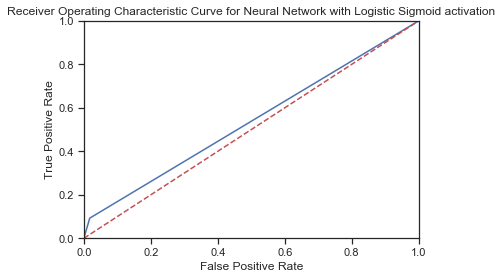


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.359544038772583 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


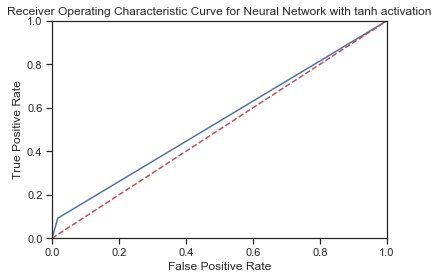


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.27181077003479004 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


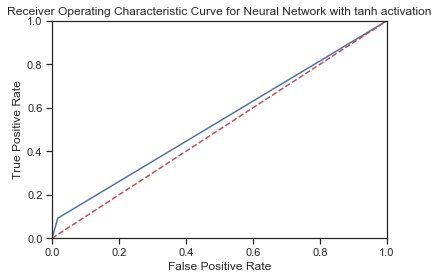


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.35277819633483887 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


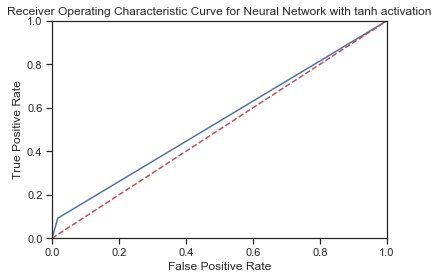


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.6285107135772705 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7506703631323002
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7484093801127067

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3983         71
True >50k       1313        134

F1-score is: 0.16222760290556898


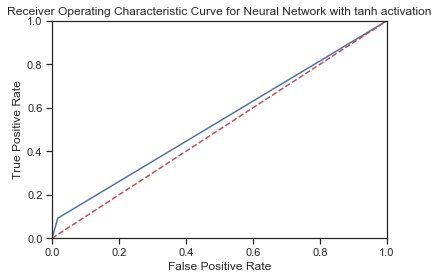


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


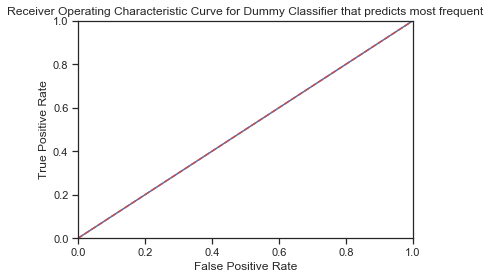


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


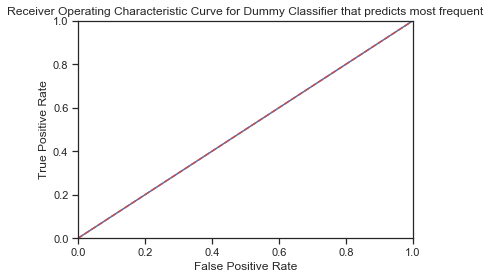


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.003984212875366211 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


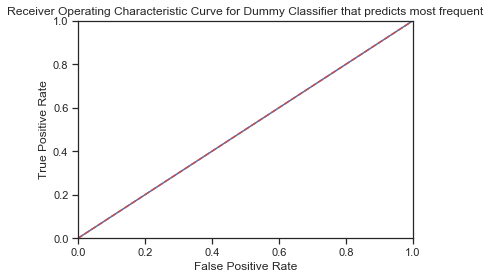


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


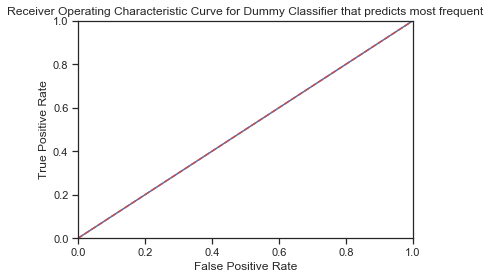


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

5.22589111328125 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


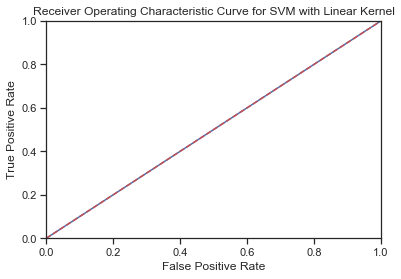


---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

5.202418327331543 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


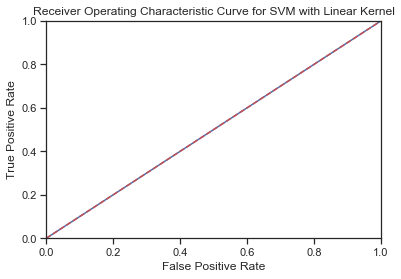


---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

5.2387659549713135 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


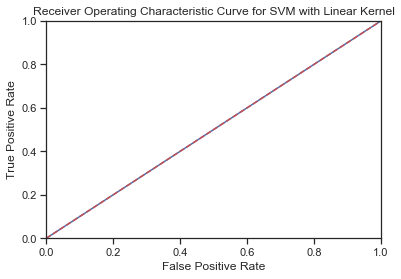


---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

5.182810068130493 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


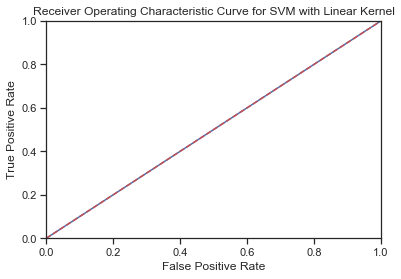


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

6.100215435028076 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7114484388492478
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7338782924613987

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2732       1322
True >50k        205       1242

F1-score is: 0.6192969334330591


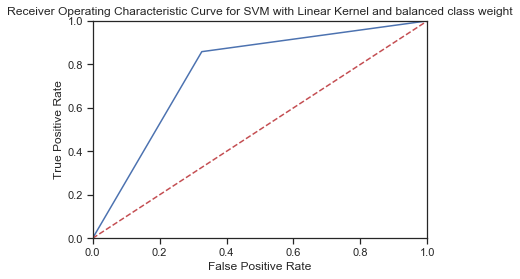


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

5.469000577926636 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7114484388492478
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7338782924613987

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2732       1322
True >50k        205       1242

F1-score is: 0.6192969334330591


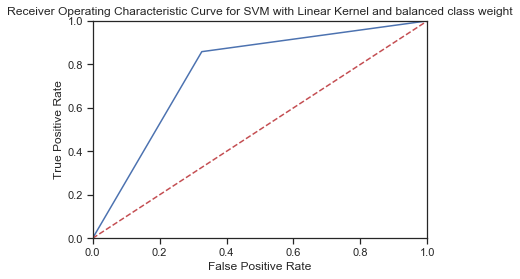


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

12.015875577926636 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7114484388492478
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7338782924613987

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2732       1322
True >50k        205       1242

F1-score is: 0.6192969334330591


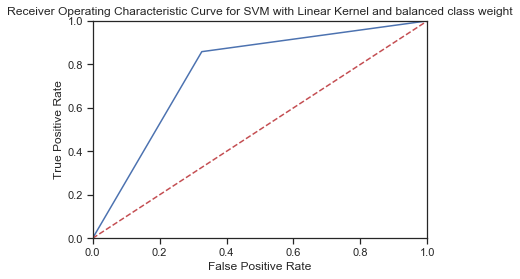


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

11.510117053985596 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7114484388492478
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7338782924613987

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2732       1322
True >50k        205       1242

F1-score is: 0.6192969334330591


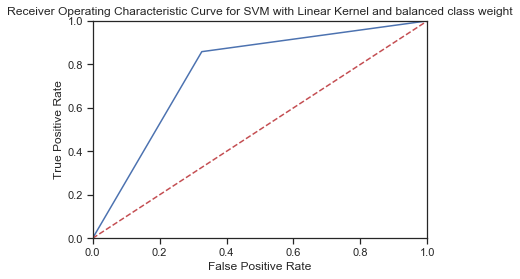


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

1.3417963981628418 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


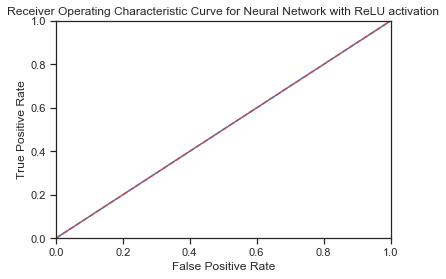


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

1.240020751953125 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


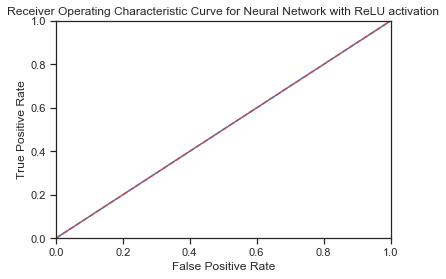


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

1.7053842544555664 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


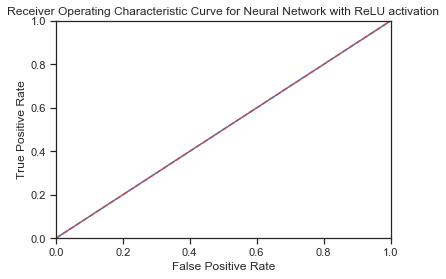


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

1.8487739562988281 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


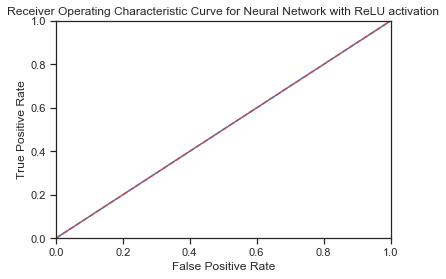


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.8380584716796875 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


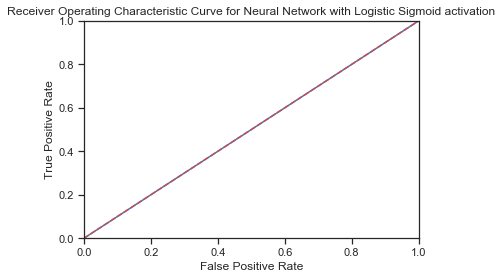


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.7649374008178711 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


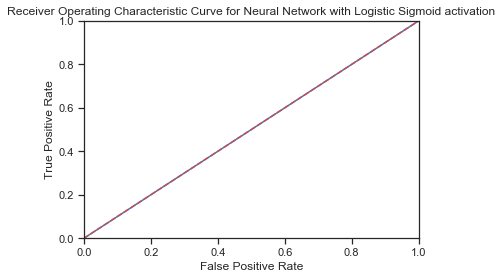


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.9096319675445557 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


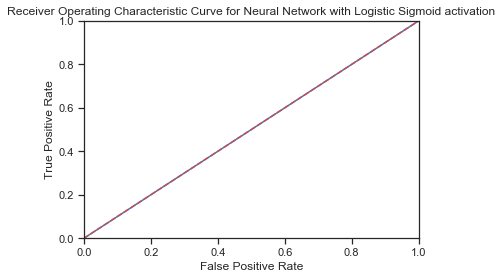


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.701469898223877 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


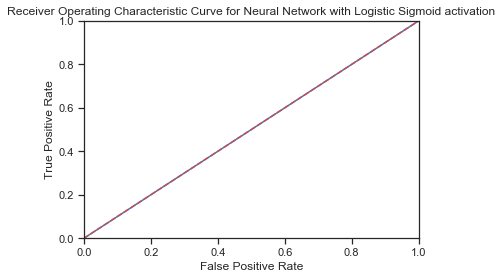


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.9725823402404785 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


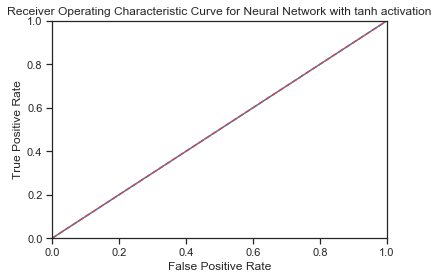


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.909555196762085 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


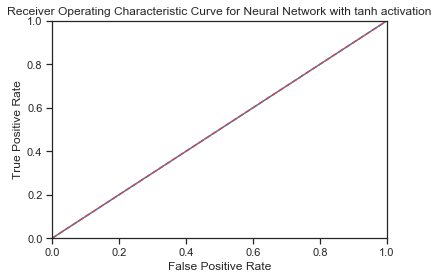


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.7909162044525146 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


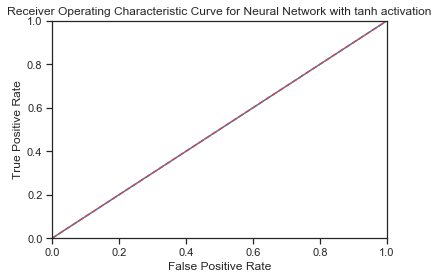


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

1.1371634006500244 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


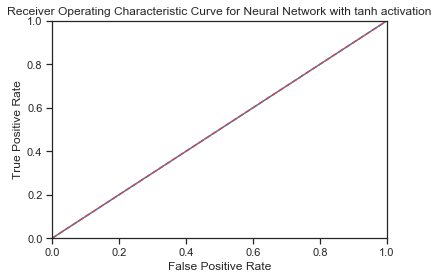


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.006703376770019531 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


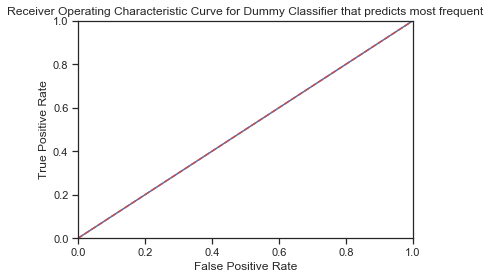


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.003781557083129883 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


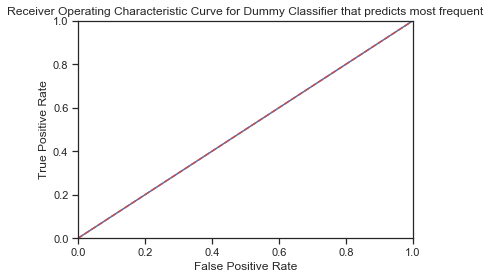


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.005537509918212891 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


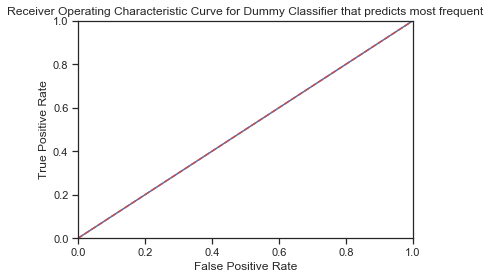


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.00869297981262207 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


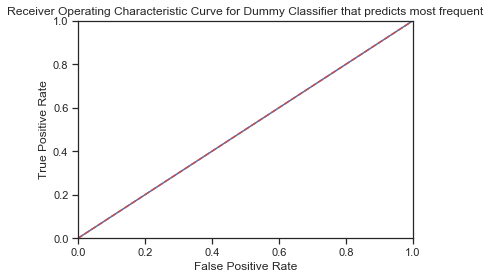


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

16.30930781364441 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7427272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


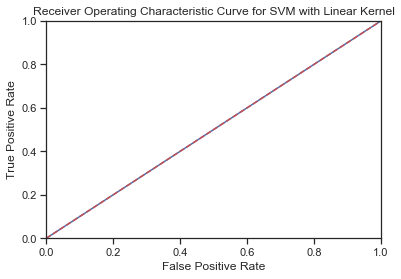


---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

17.263679027557373 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7427272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


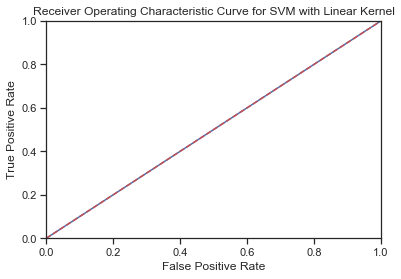


---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

17.35296368598938 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7427272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


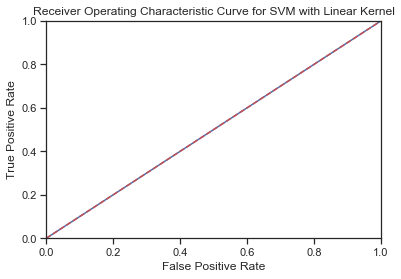


---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

17.908638954162598 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7427272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


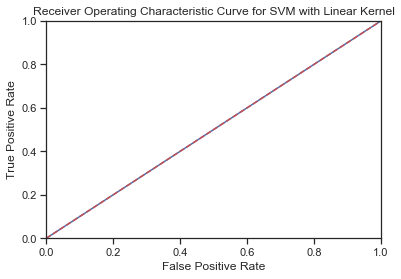


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

26.664362907409668 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6516384129436895
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6848319709355132

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2634       1420
True >50k        446       1001

F1-score is: 0.5175801447776628


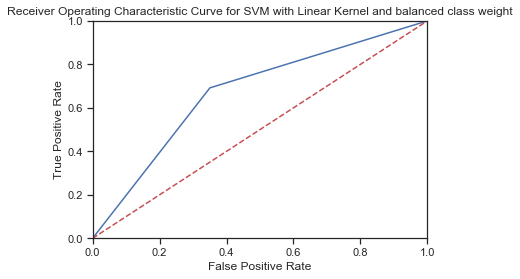


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

23.13996958732605 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6516384129436895
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6848319709355132

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2634       1420
True >50k        446       1001

F1-score is: 0.5175801447776628


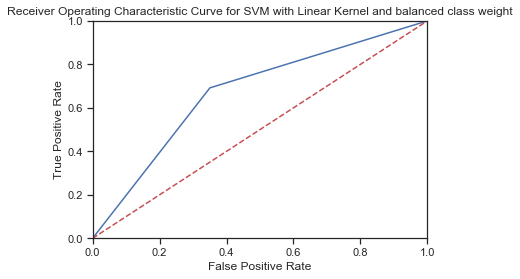


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

25.33616280555725 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6516384129436895
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6848319709355132

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2634       1420
True >50k        446       1001

F1-score is: 0.5175801447776628


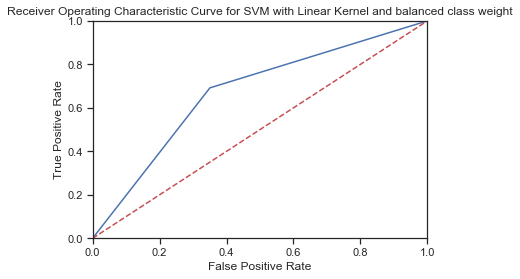


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

26.848782300949097 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6516384129436895
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6848319709355132

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2634       1420
True >50k        446       1001

F1-score is: 0.5175801447776628


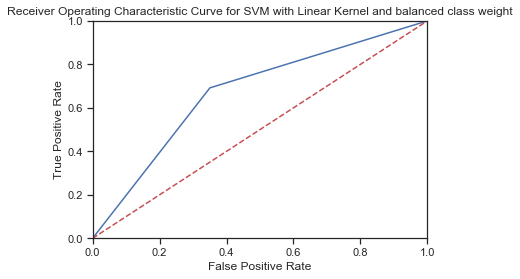


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

1.1472909450531006 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


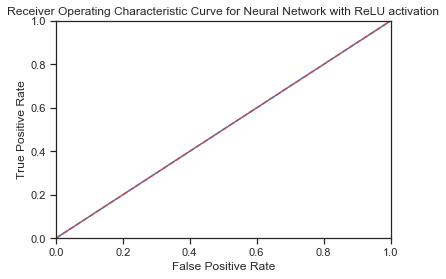


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

2.2439167499542236 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


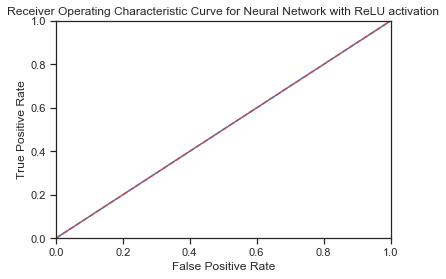


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

2.057788372039795 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


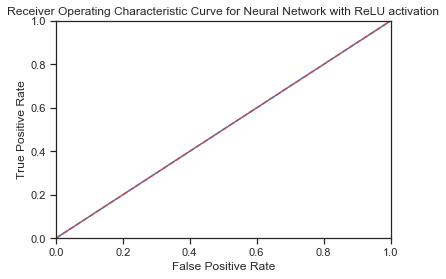


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

1.3335824012756348 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


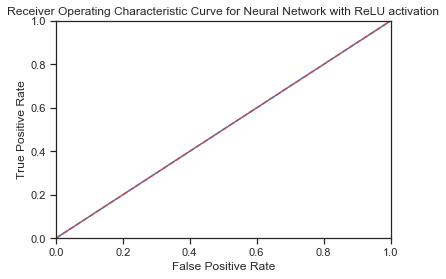


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.9504778385162354 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


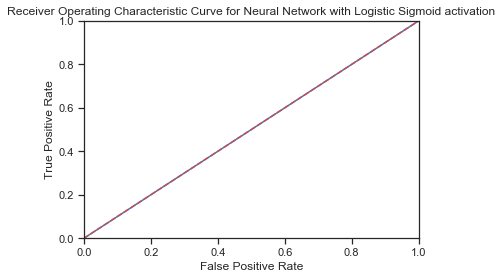


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

1.1565864086151123 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


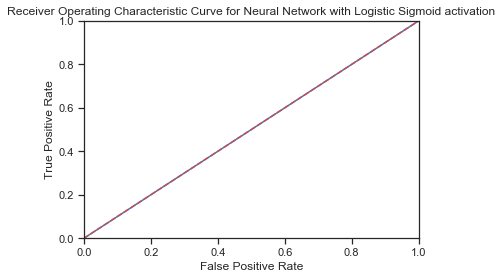


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

1.1081175804138184 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


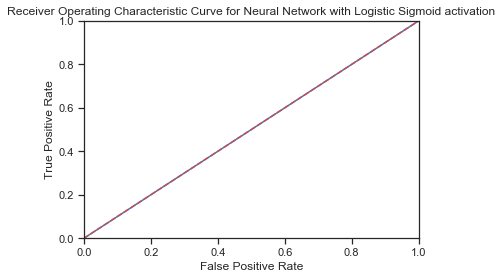


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.9872162342071533 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


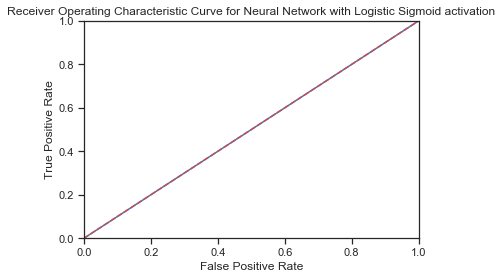


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

1.449554681777954 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


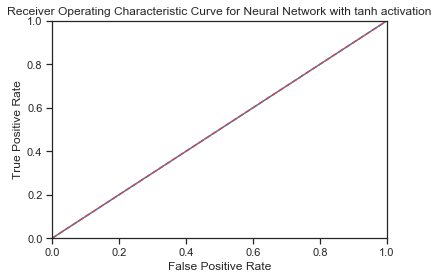


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

1.7160098552703857 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


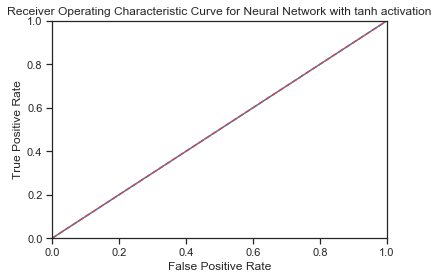


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

1.6154704093933105 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


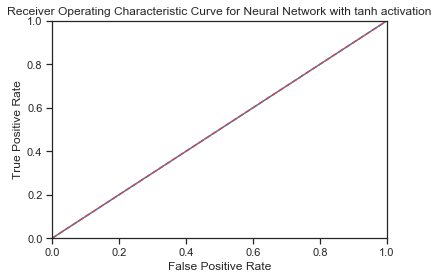


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

1.525527000427246 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


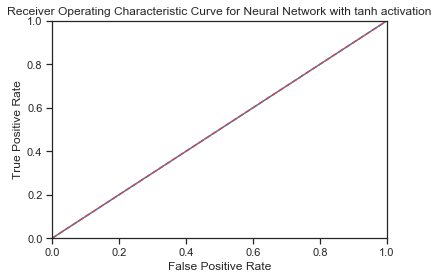


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.003993511199951172 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


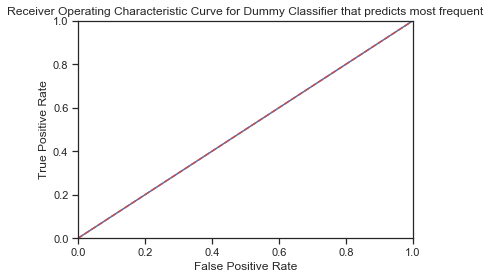


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.007265806198120117 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


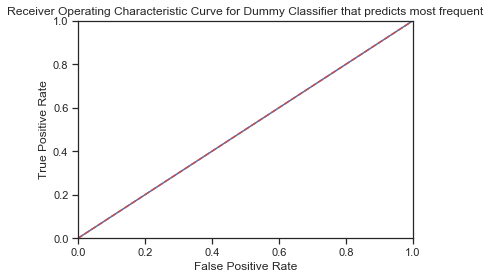


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.009122848510742188 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


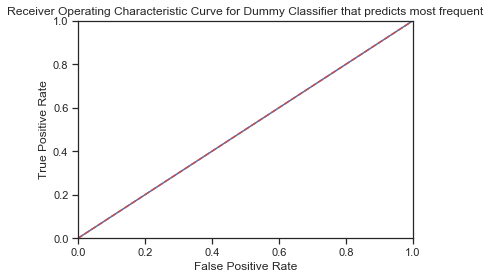


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.008136987686157227 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


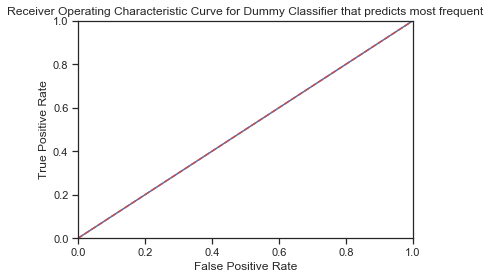


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

11.237947463989258 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7472727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


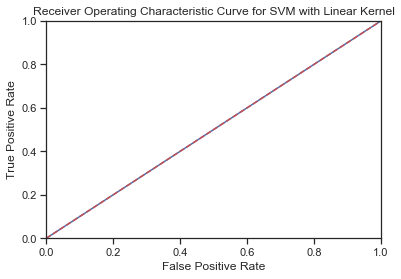


---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

11.108533143997192 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7472727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


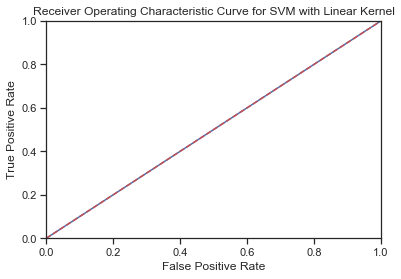


---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

11.67471194267273 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7472727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


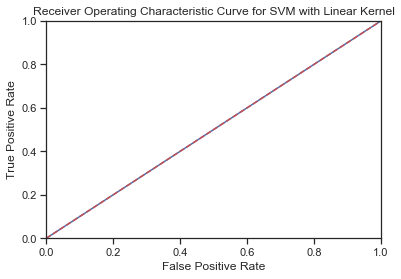


---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

11.478397130966187 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7472727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


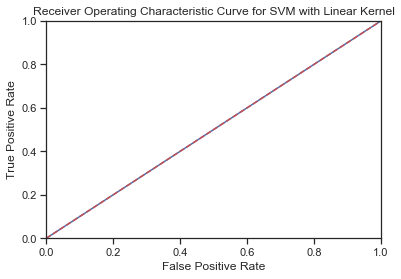


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

12.942649602890015 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7146298232059265
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.737511353315168

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2762       1292
True >50k        210       1237

F1-score is: 0.6222334004024145


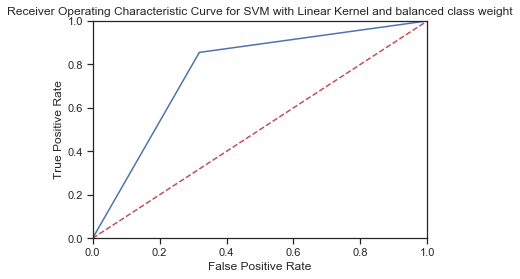


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

11.782439947128296 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7146298232059265
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.737511353315168

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2762       1292
True >50k        210       1237

F1-score is: 0.6222334004024145


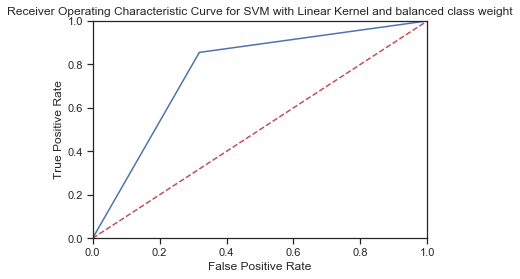


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

12.834497213363647 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7146298232059265
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.737511353315168

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2762       1292
True >50k        210       1237

F1-score is: 0.6222334004024145


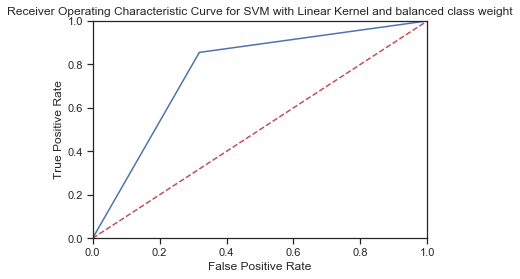


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

13.280652523040771 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7146298232059265
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.737511353315168

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2762       1292
True >50k        210       1237

F1-score is: 0.6222334004024145


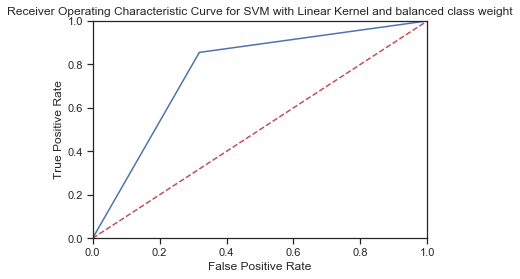


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

1.2679874897003174 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


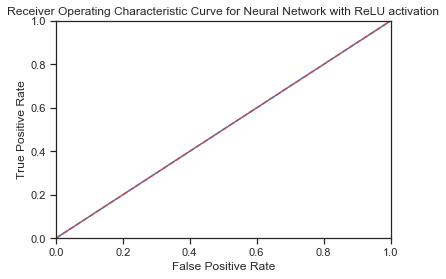


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

1.4907312393188477 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


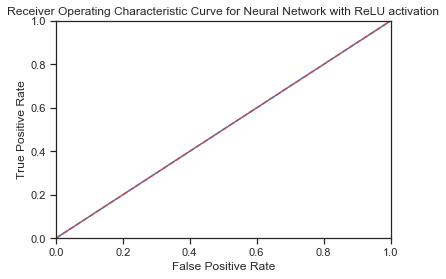


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

1.4655563831329346 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


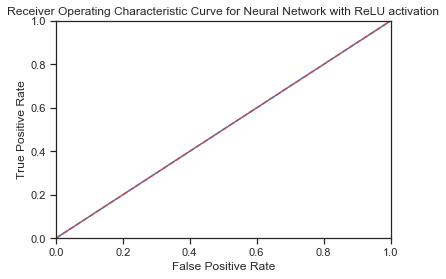


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

1.7919285297393799 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


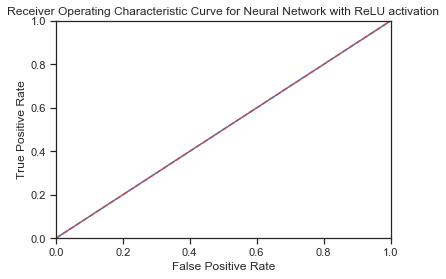


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.8358163833618164 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


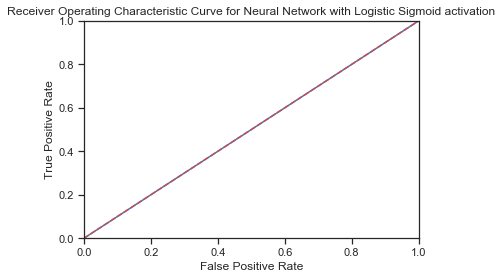


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.6312038898468018 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


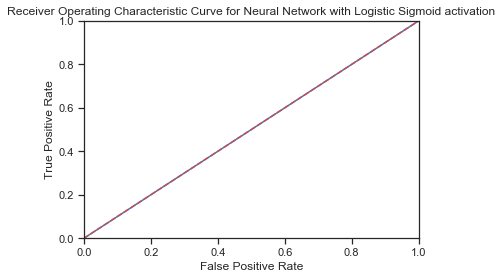


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

1.014345645904541 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


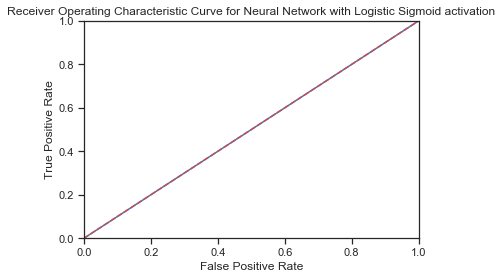


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.8562312126159668 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


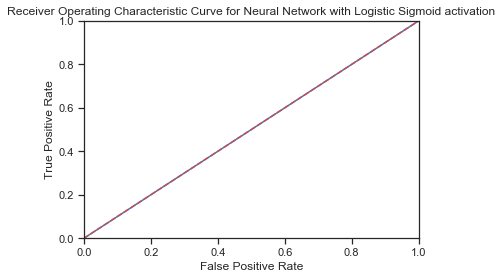


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.8014435768127441 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


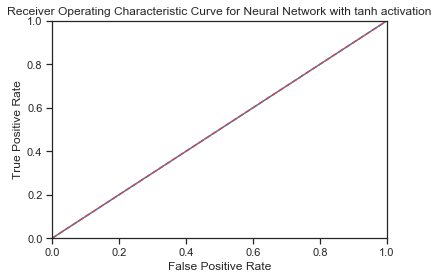


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.6362903118133545 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


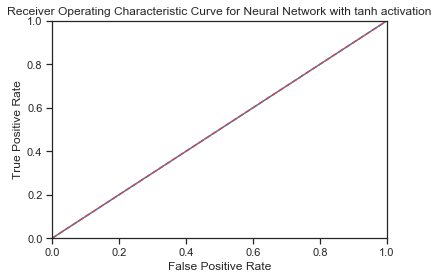


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

1.6227614879608154 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


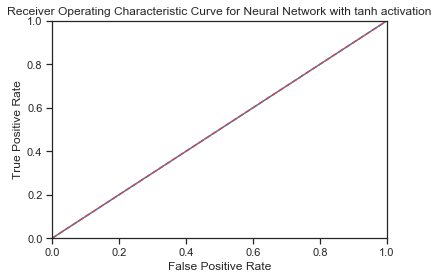


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.7840940952301025 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


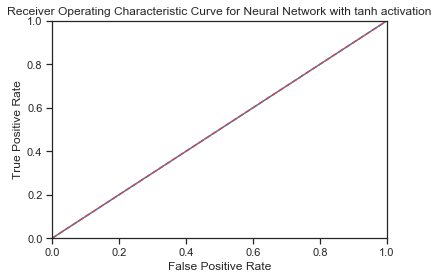


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.00628209114074707 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


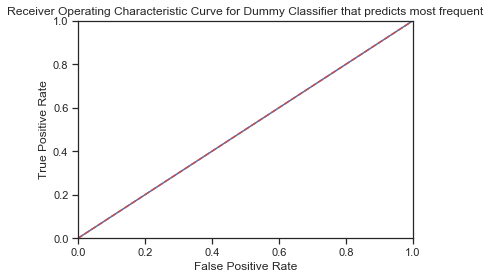


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.004126071929931641 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


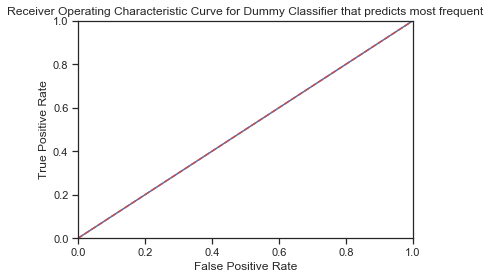


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.004812717437744141 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


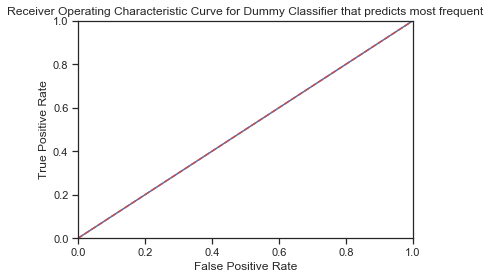


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.0072782039642333984 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


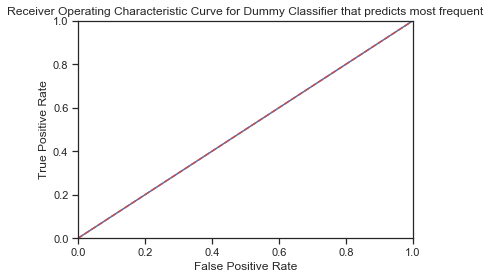


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

8.75720739364624 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


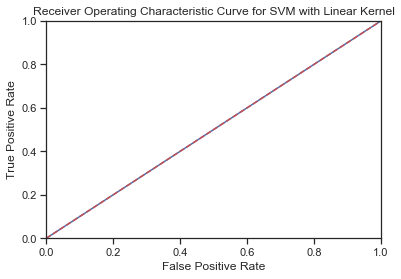


---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

8.869621276855469 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


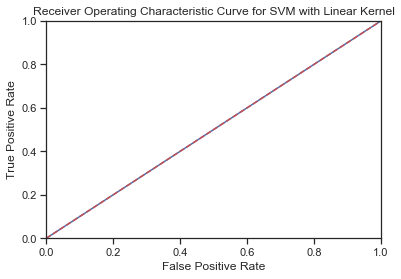


---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

8.010538816452026 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


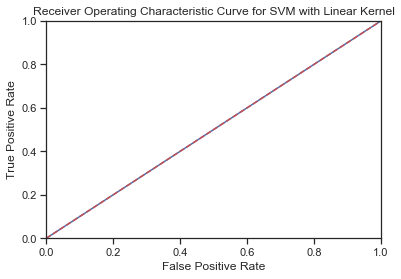


---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

8.425941944122314 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


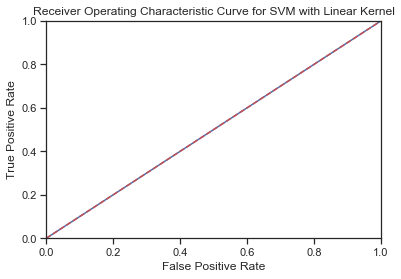


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

18.445530652999878 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.3385901922465118
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.35577797998180166

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        561       3493
True >50k         89       1358

F1-score is: 0.43124801524293427


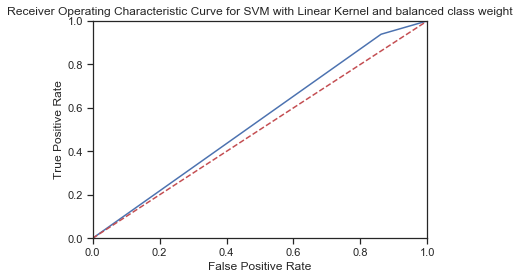


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

15.255097389221191 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.3385901922465118
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.35577797998180166

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        561       3493
True >50k         89       1358

F1-score is: 0.43124801524293427


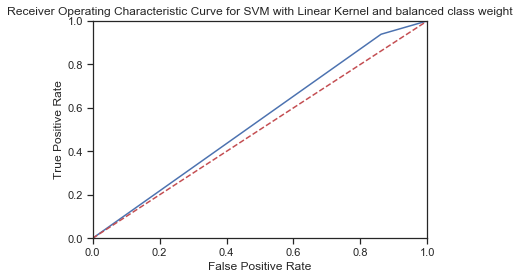


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

15.661883354187012 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.3385901922465118
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.35577797998180166

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        561       3493
True >50k         89       1358

F1-score is: 0.43124801524293427


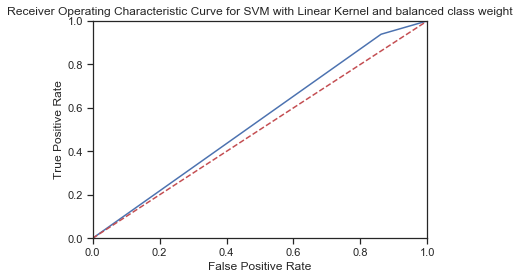


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

15.696367740631104 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.3385901922465118
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.35577797998180166

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        561       3493
True >50k         89       1358

F1-score is: 0.43124801524293427


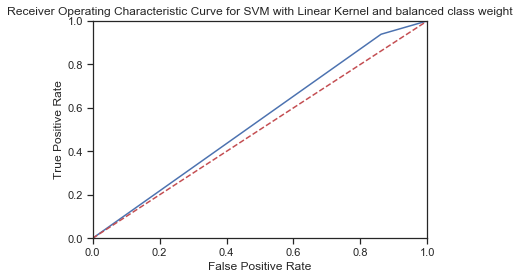


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.533132791519165 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


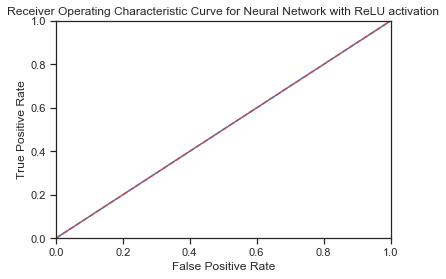


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.853395938873291 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


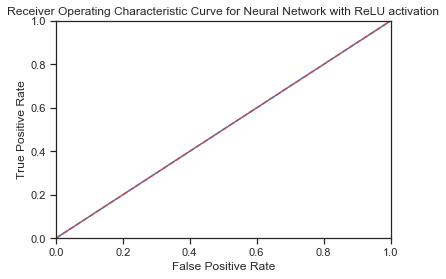


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.3941676616668701 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


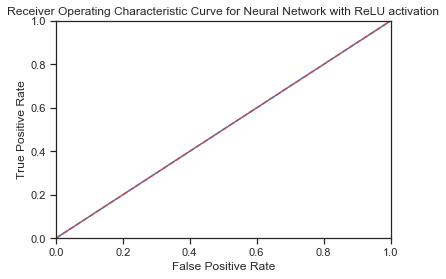


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.3874669075012207 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


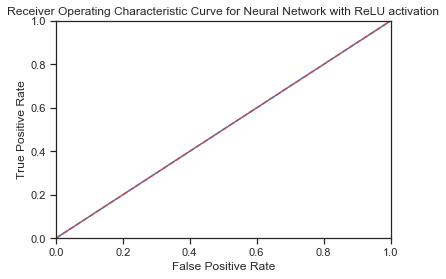


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.4165642261505127 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


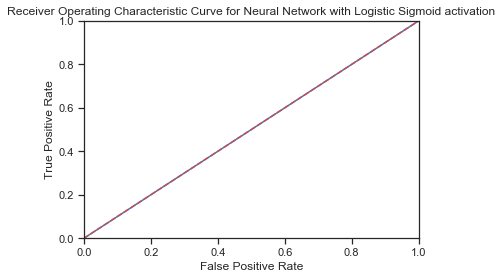


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.3472297191619873 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


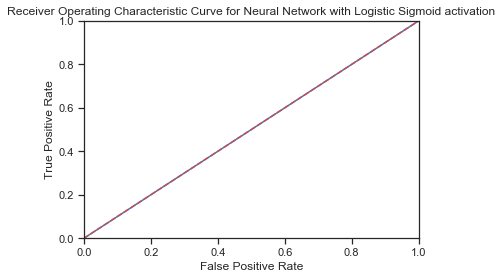


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.7163009643554688 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


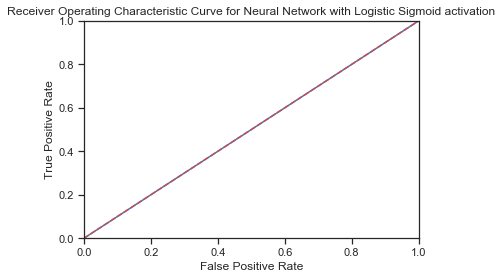


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.3123636245727539 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


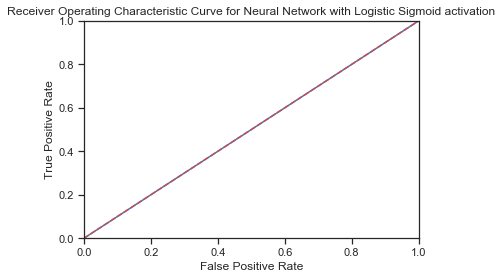


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.28999805450439453 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


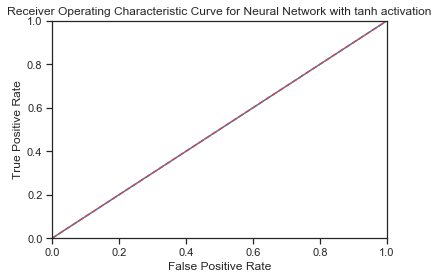


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.42711901664733887 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


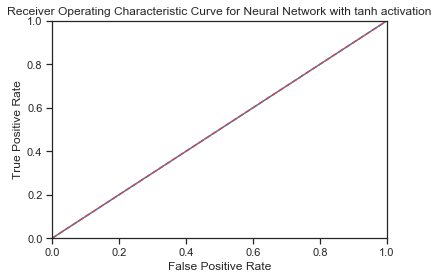


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.38462138175964355 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


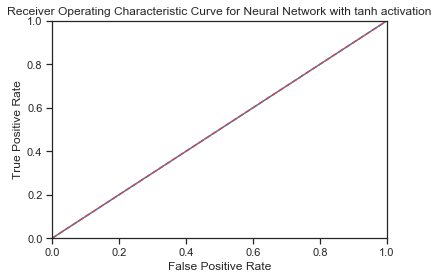


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.28301024436950684 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


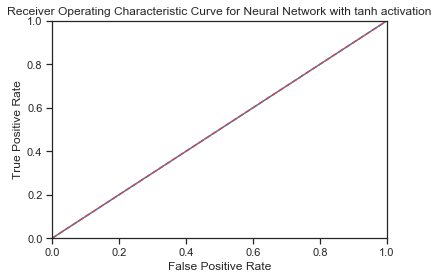


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.0040357112884521484 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


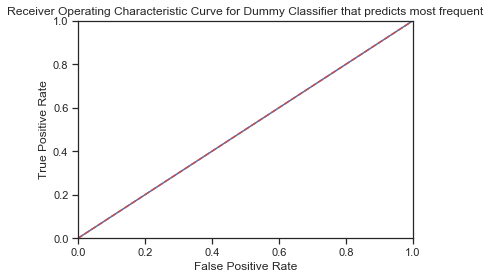


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.00399470329284668 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


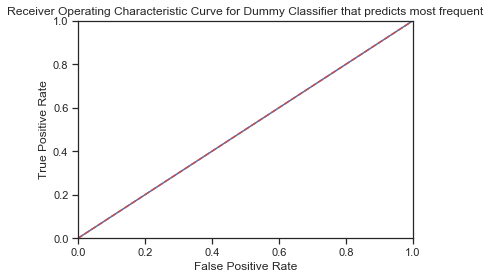


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.004055023193359375 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


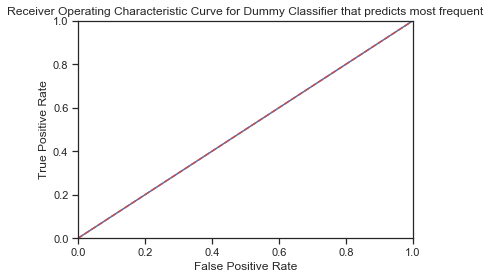


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.00412440299987793 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


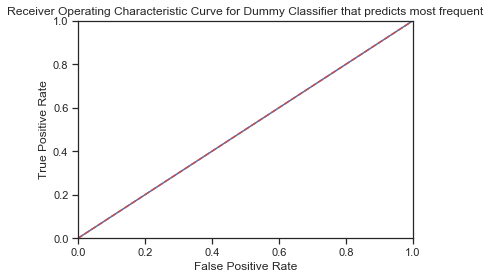


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

57.13315725326538 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8445666500022724
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8510445049954587

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        575        872

F1-score is: 0.6730991895021227


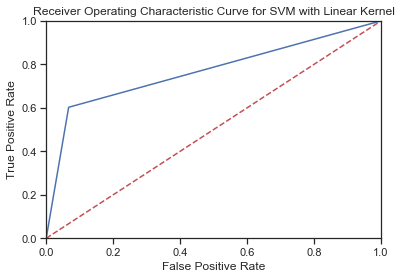


---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

56.91284704208374 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8445666500022724
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8510445049954587

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        575        872

F1-score is: 0.6730991895021227


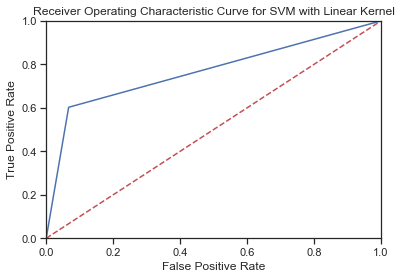


---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

58.0191855430603 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8445666500022724
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8510445049954587

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        575        872

F1-score is: 0.6730991895021227


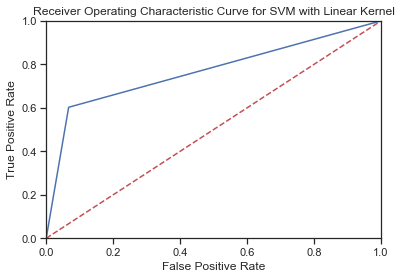


---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

58.01376271247864 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8445666500022724
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8510445049954587

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        575        872

F1-score is: 0.6730991895021227


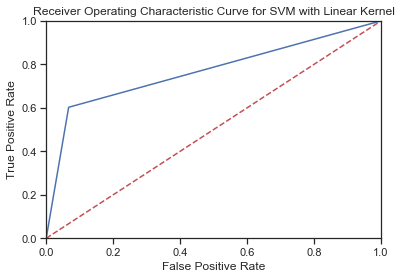


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

70.39107608795166 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7876198700177248
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.82

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3189        865
True >50k        194       1253

F1-score is: 0.7029453015427769


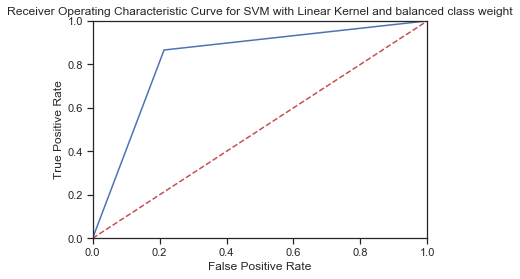


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

70.65194749832153 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7876198700177248
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.82

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3189        865
True >50k        194       1253

F1-score is: 0.7029453015427769


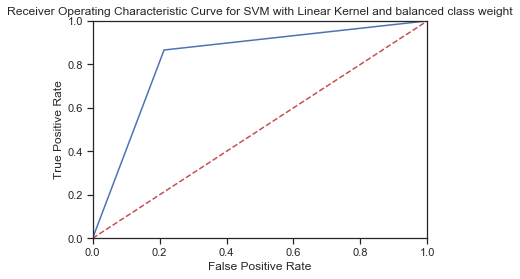


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

70.85509204864502 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7876198700177248
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.82

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3189        865
True >50k        194       1253

F1-score is: 0.7029453015427769


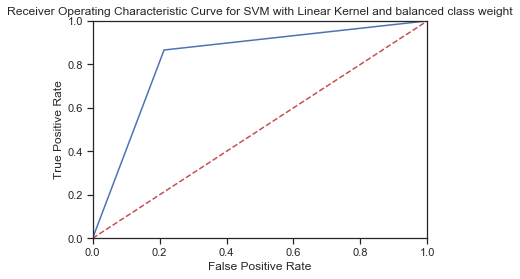


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

756.09375 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7876198700177248
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.82

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3189        865
True >50k        194       1253

F1-score is: 0.7029453015427769


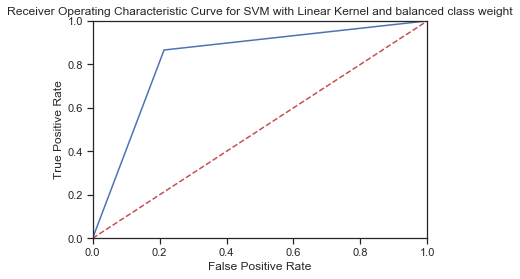


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

3.285222053527832 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8552015634231696
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8576622432285039

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3774        280
True >50k        503        944

F1-score is: 0.7068513665293897


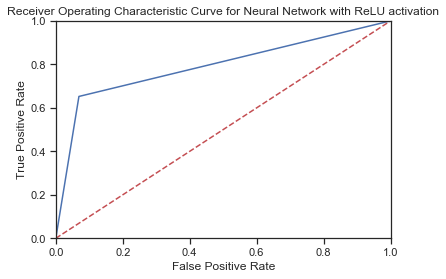


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

3.5758893489837646 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8527928009816843
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8505726231594256

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3770        284
True >50k        538        909

F1-score is: 0.6886363636363637


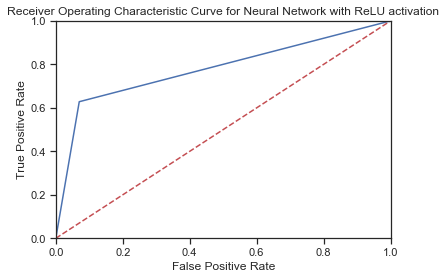


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

3.696420669555664 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.85342907785302
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8511179785493547

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        547        900

F1-score is: 0.6872852233676977


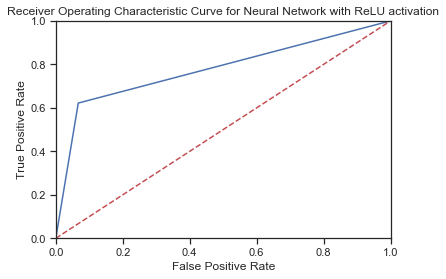


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

3.9536240100860596 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8526564559378267
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8560261770587166

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3783        271
True >50k        521        926

F1-score is: 0.7004538577912254


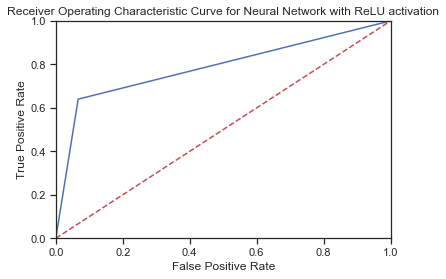


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

3.336352825164795 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.85342907785302
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8529358298491183

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3759        295
True >50k        514        933

F1-score is: 0.697570093457944


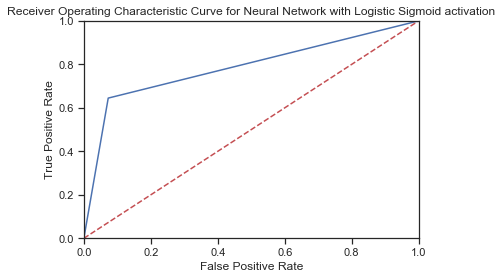


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

2.7389607429504395 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8529291460255419
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8529358298491183

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3769        285
True >50k        524        923

F1-score is: 0.6952919020715631


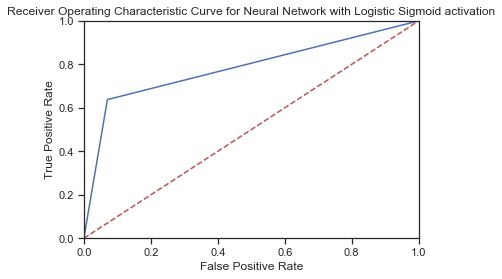


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

2.9345316886901855 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8543380448120711
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8532994001090711

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3769        285
True >50k        522        925

F1-score is: 0.6962739932254423


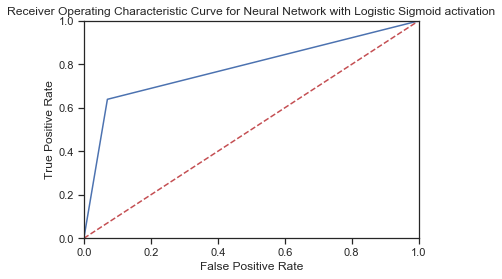


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

4.036178112030029 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8526564559378267
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8502090528994728

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3768        286
True >50k        538        909

F1-score is: 0.6881150643451931


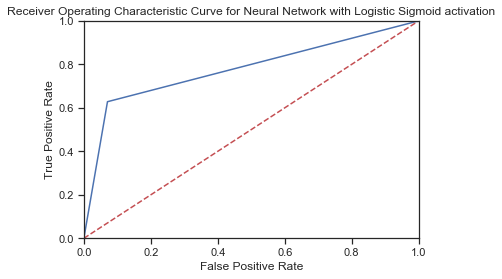


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

3.700608491897583 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8537017679407354
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8534811852390475

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3782        272
True >50k        534        913

F1-score is: 0.6937689969604864


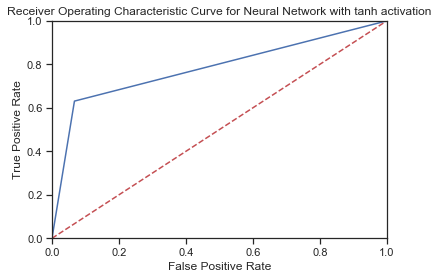


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

3.647603988647461 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8562468754260782
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8552990365388111

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3771        283
True >50k        513        934

F1-score is: 0.7012012012012012


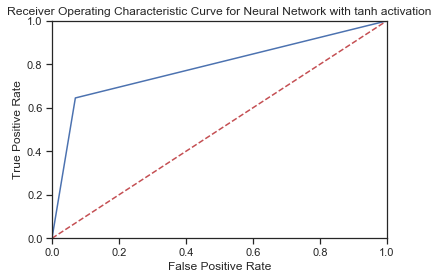


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

3.4727652072906494 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8557469435986002
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8529358298491183

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3764        290
True >50k        519        928

F1-score is: 0.6964352720450282


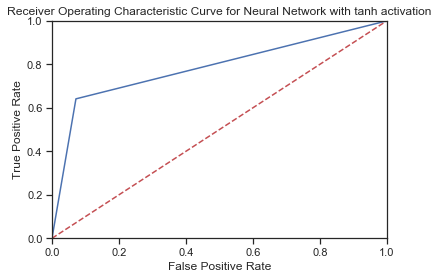


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

3.807095527648926 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8543834931600236
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8531176149790947

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3758        296
True >50k        512        935

F1-score is: 0.6982823002240478


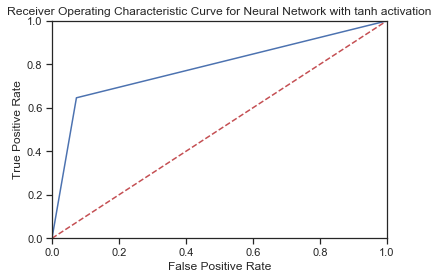


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.003995180130004883 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


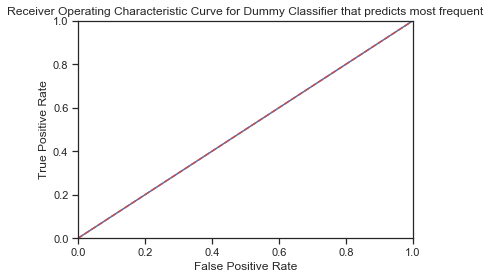


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.00399470329284668 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


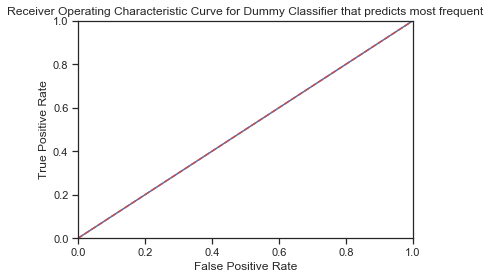


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.0039942264556884766 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


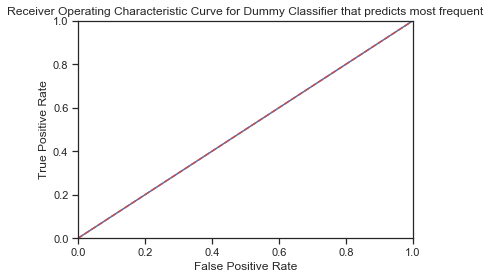


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.003996610641479492 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.747852565559242
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7369569169241956

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054          0
True >50k       1447          0

F1-score is: 0.0


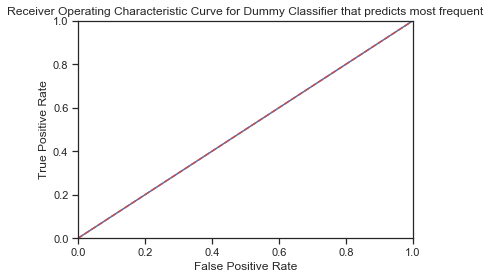

In [37]:
Y = np.array(new_df.iloc[:,45:46]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

# matrix with the quality criteria
test_accuracies = np.zeros((len(ranges), len(classifiers)))
train_accuracies = np.zeros((len(ranges), len(classifiers)))
f1_scores = np.zeros((len(ranges), len(classifiers)))

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 0 or j == 1:   # if it is svm do cross validation
            return_results(classifiers[j],names[j],True,False,i)
            test_accuracies[i,j] = return_results(classifiers[j],names[j],True,False,i)[0]
            train_accuracies[i,j] = return_results(classifiers[j],names[j],True,False,i)[1]
            f1_scores[i,j] = return_results(classifiers[j],names[j],True,False,i)[2]

        elif j == 5:  # if it is a dummyclassifier, calculate accuracy the proper way
            return_results(classifiers[j],names[j],False,True,i)  
            test_accuracies[i,j] = return_results(classifiers[j],names[j],False,True,i)[0]
            train_accuracies[i,j] = return_results(classifiers[j],names[j],False,True,i)[1]
            f1_scores[i,j] = return_results(classifiers[j],names[j],False, True, i)[2]
        else:    # if a regular classifier, just do the normal operations
            return_results(classifiers[j],names[j],False,False,i)
            test_accuracies[i,j] = return_results(classifiers[j],names[j],False,False,i)[0]
            train_accuracies[i,j] = return_results(classifiers[j],names[j],False,False,i)[1]
            f1_scores[i,j] = return_results(classifiers[j],names[j],False,False,i)[2]

In [44]:
names

['SVM with Linear Kernel',
 'SVM with Linear Kernel and balanced class weight',
 'Neural Network with ReLU activation',
 'Neural Network with Logistic Sigmoid activation',
 'Neural Network with tanh activation',
 'Dummy Classifier that predicts most frequent']

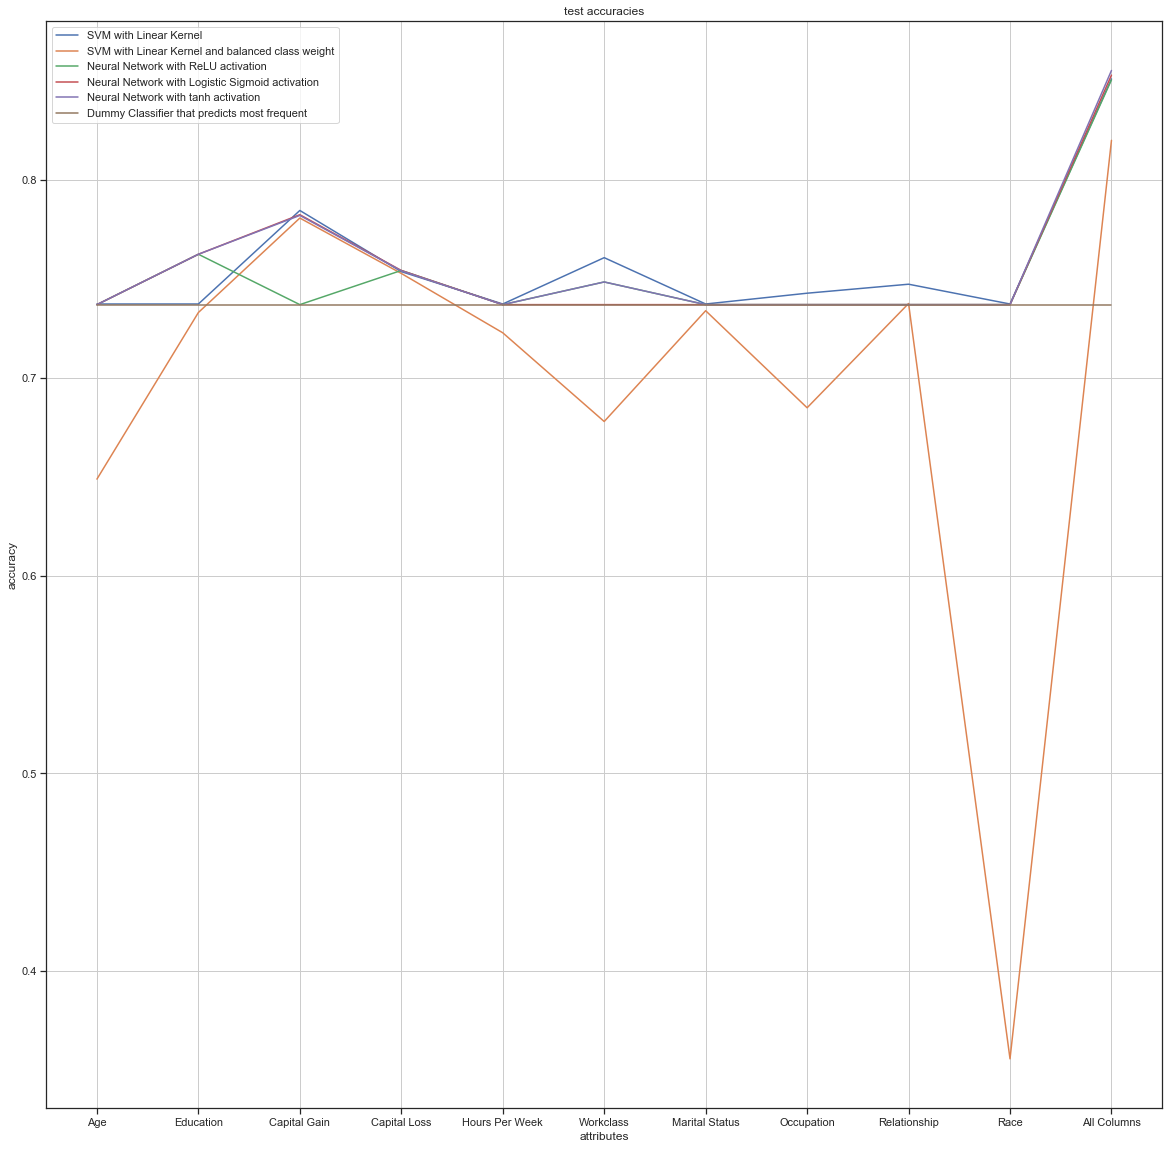

In [48]:
## Visualizing test accuracy

test_accuracies_svm_LK = test_accuracies[:,0]
test_accuracies_svm_LK_cw = test_accuracies[:,1]
test_accuracies_NN_ReLU = test_accuracies[:,2]
test_accuracies_NN_LSa = test_accuracies[:,3]
test_accuracies_NN_tanh = test_accuracies[:,4]
test_accuracies_DCLF = test_accuracies[:,5]


plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(columns, test_accuracies_svm_LK, label= names[0])
ax.plot(columns, test_accuracies_svm_LK_cw, label = names[1])
ax.plot(columns, test_accuracies_NN_ReLU, label = names[2])
ax.plot(columns, test_accuracies_NN_LSa, label = names[3])
ax.plot(columns, test_accuracies_NN_tanh, label = names[4])
ax.plot(columns, test_accuracies_DCLF, label = names[5])


ax.set(xlabel='attributes', ylabel='accuracy',
       title='test accuracies')
ax.grid()
plt.legend()

fig.savefig("test_accuracies.png")

plt.show()

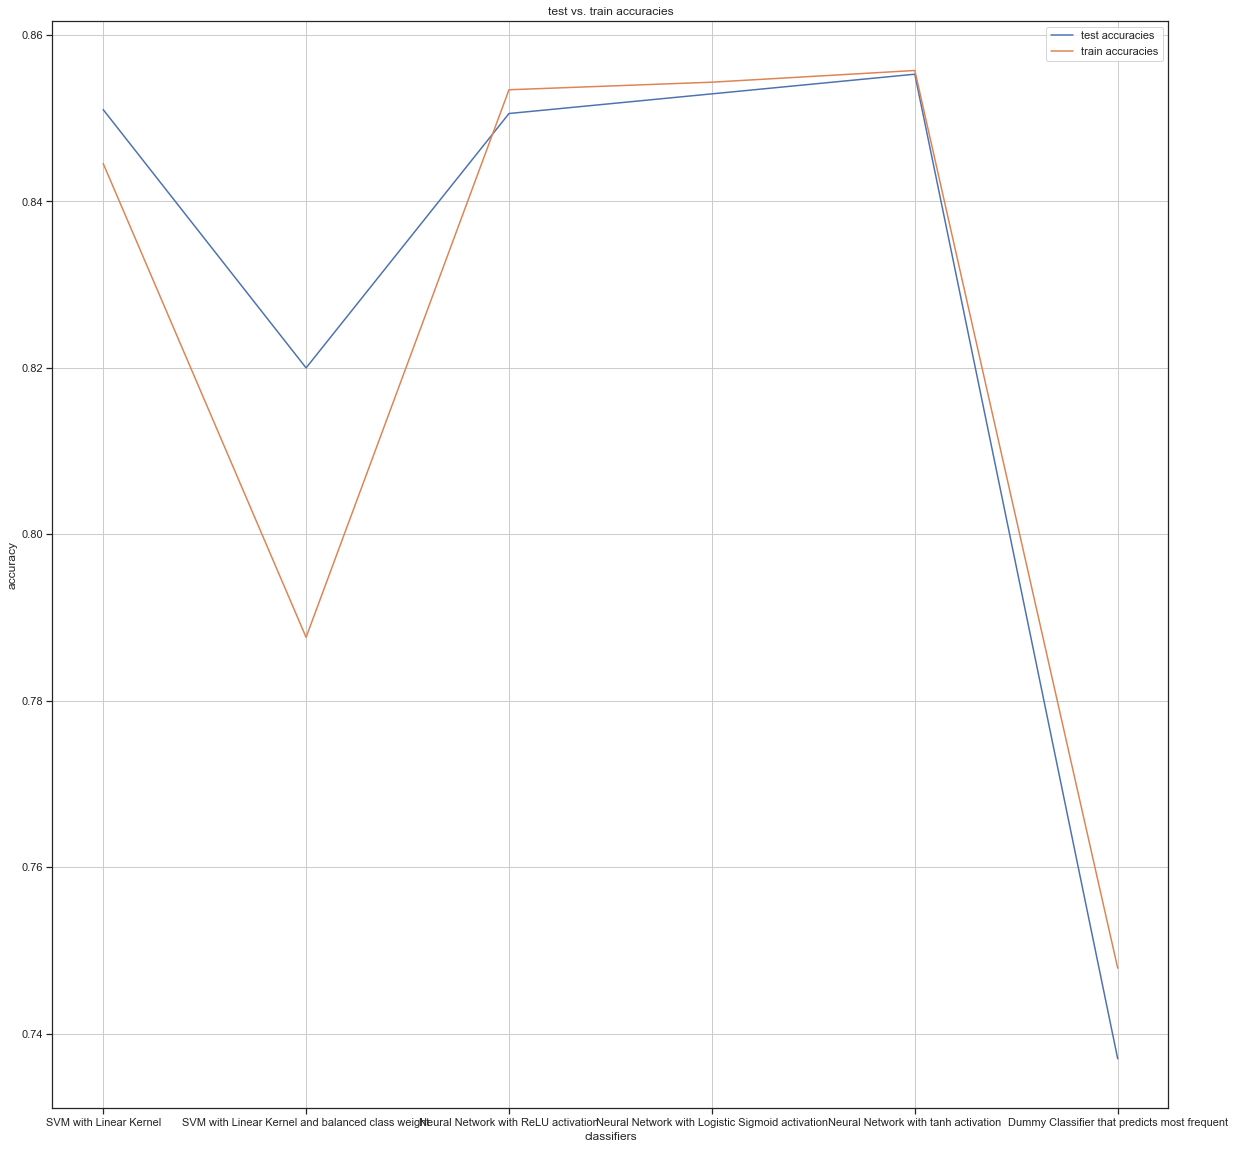

In [51]:
# visualizing test versus train accuracy

plt.rcParams["figure.figsize"] = (20,20)

test_acc_all_var = test_accuracies[-1,:]
train_acc_all_var = train_accuracies[-1,:]

fig, ax = plt.subplots()
ax.plot(names, test_acc_all_var, label= 'test accuracies')
ax.plot(names, train_acc_all_var, label= 'train accuracies')



ax.set(xlabel='classifiers', ylabel='accuracy',
       title='test vs. train accuracies')
ax.grid()
plt.legend()

fig.savefig("test_vs_train_accuracies.png")

plt.show()

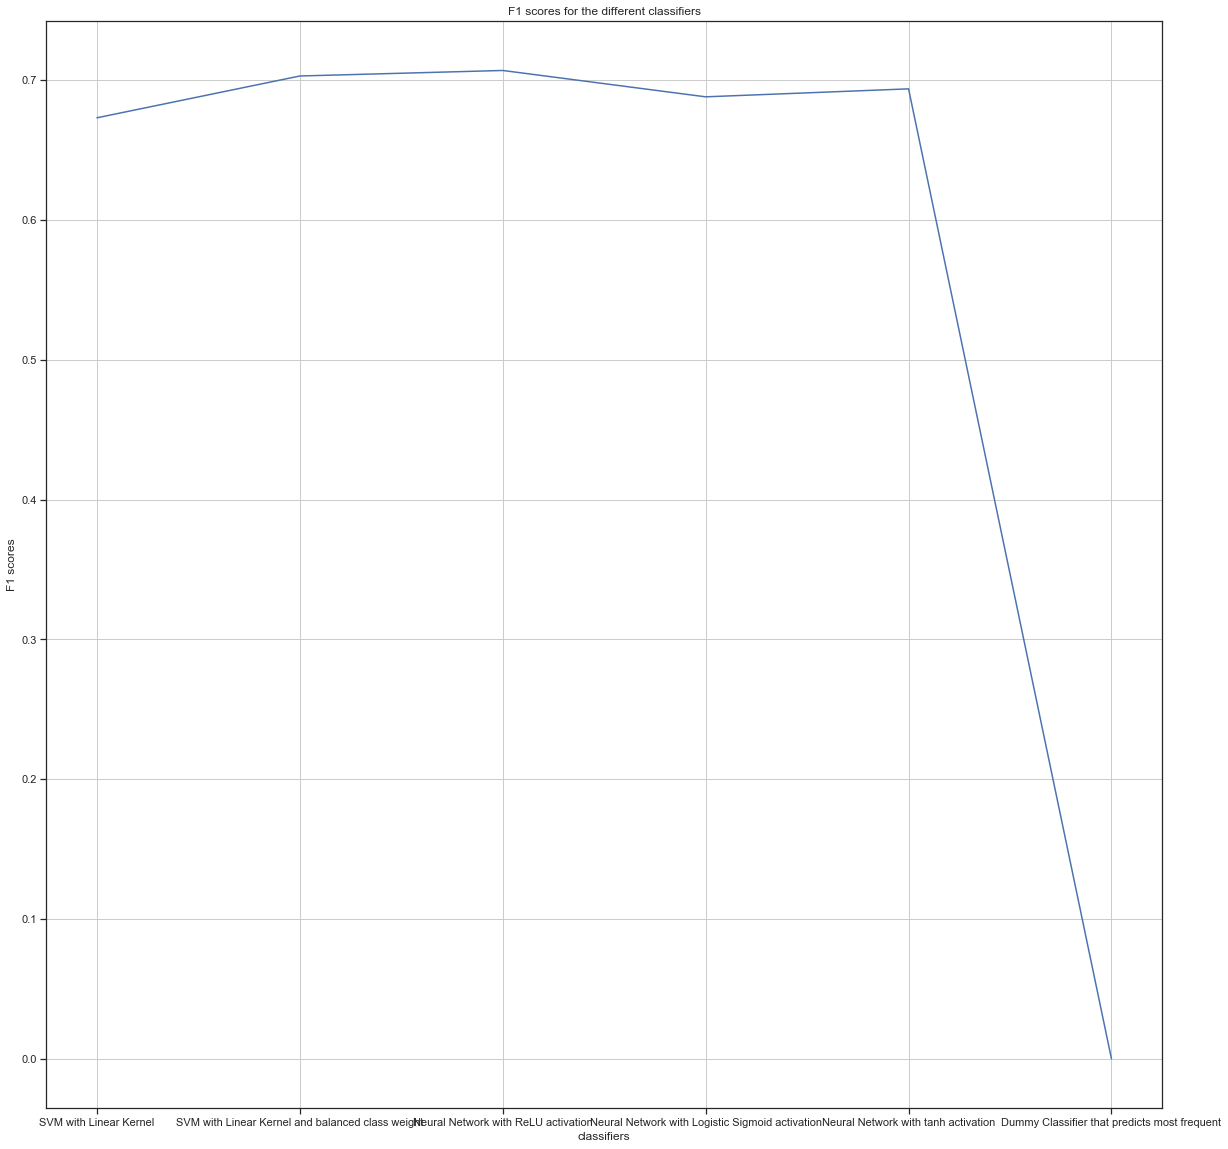

In [54]:
# plot F1 scores

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(names, f1_scores[-1,:])


ax.set(xlabel='classifiers', ylabel='F1 scores',
       title='F1 scores for the different classifiers')
ax.grid()

fig.savefig("F1_scores.png")

plt.show()